# ทำนายทิศทางและราคาหุ้นในอีก 5 วันข้างหน้า
วิธีการคือ
1. เตรียมข้อมูล dataset 
2. สร้าง Model Prediction
3. ทำนายค่า 

*ไฟล์ colab ทำขึ้นเพื่อการศึกษาflowการทำนาย library ต่างๆจึงไม่ได้ทำเป็น class
* Compose by Khun A

Install library ใน colab ก่อน เพื่อจะใช้งานในโปรแกรม

In [1]:
%%capture  
#ติดตั้ง library talib เพื่อใช้สร้าง indicator หุ้น
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

#ติดตั้ง library starfishX เพื่อดึงข้อมูลตลาดหุ้น กรณีต้องการใช้ข้อมูลจาก starfishX
!pip install starfishX  

!pip install eli5

# 1. เตรียมข้อมูล dataset
###  1.1 แหล่งข้อมูล เราสามารถดึงข้อมูลหุ้นได้จากหลายวิธี เช่น web scraping, api, file 
  ในที่นี้จะใช้ข้อมูลจาก api เพราะข้อมูล up to date ตลอด และ stable สุด 

In [2]:
# import library หลักสำหรับใช้งาน
import talib   # library for create Indicator
import talib.abstract as talib_abstract

import pandas as pd
import pandas
import numpy as np
import numpy
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})  #จัดทศนิยมในโปรแกรมให้แสดง 5 ตำแหน่ง

In [3]:
# กำหนด start_date คือวันที่เริ่มต้นของข้อมูลหุ้น
# end_date คือวันที่ปัจจุบัน หรือวันที่ที่ต้องการทดสอบ 
start_date = '2018-01-01 00:00:00.000'
#end_date = '2020-10-15 00:00:00.000'
end_date = datetime.datetime.today()  # ใช้วันที่ปัจจุบัน

# กำหนดจำนวนวันที่จะทำนายล่วงหน้า
p_day = 5

In [4]:
# #ถ้าต้องการถึงข้อมูลจาก starfishX ให้เปิดส่วนนี้ กด ctrl /  ดึงข้อมูลย้อนหลังได้มากกว่า yahoo
# #มีข้อมูลพื้นฐานของหุ้นให้ด้วย 
# import starfishX as sx   

# # Create get_stock function to pull stock data จาก startfishX จะเป็นข้อมูลรายวัน daily 
# def get_stock(stock, startdate, enddate):
#   df = sx.loadHistData(stock, start=startdate, end=enddate, OHLC=True, Volume=True)
#   return df

# # ใส่ชื่อหุ้นที่ต้องการ 
# stock_symbol = 'ADVANC'
# df = get_stock(stock=stock_symbol, startdate=start_date, enddate=end_date)

In [5]:
#ถ้าต้องการถึงข้อมูลจาก Yahoo Finance ให้เปิดส่วนนี้ กด ctrl /  ใน Production เราจะดึงข้อมูลจากแหล่งต่างๆแล้ว save ลง database
from pandas_datareader import data as pdr

# Create getStockPrice function to pull stock data จาก yahoo finance 
def getStockPrice(symbol, startDate, endDate):
    return pdr.get_data_yahoo(symbol, start=startDate, end=endDate)

# ใส่ชื่อหุ้นที่ต้องการ 
stock_symbol = 'KBANK'
df = getStockPrice(stock_symbol+'.BK', start_date, end_date)

# ปรับชื่อ columns ให้เป็นระเบียบ  กำหนด date ให้เป็น index ของ data frame
df.index = pd.DatetimeIndex(df.index)
df = df.rename(columns={'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'})
df.drop(columns=['Adj Close'], inplace=True)
#df = df[['open','high','low','close','volume']]  #ใช้กรณีต้องการเรียง column ใหม่
print(df)

             high    low   open  close      volume
Date                                              
2018-01-03  237.0  233.0  234.0  237.0   6816400.0
2018-01-04  244.0  238.0  239.0  242.0   8123000.0
2018-01-05  244.0  240.0  242.0  241.0   6622100.0
2018-01-08  245.0  241.0  243.0  241.0   8454800.0
2018-01-09  240.0  234.0  240.0  235.0  13325700.0
...           ...    ...    ...    ...         ...
2021-02-01  133.0  127.0  127.5  132.0  33845200.0
2021-02-02  135.0  130.5  135.0  131.0  22938300.0
2021-02-03  135.0  132.0  134.0  133.5  30346200.0
2021-02-04  137.0  132.0  134.5  135.0  23766300.0
2021-02-05  138.0  136.0  136.5  138.0  17134200.0

[757 rows x 5 columns]


In [6]:
# ข้อมูลเพิ่มเติมสำหรับสร้าง Features เช่น ดัชนี Nasdaq, DownJones30, S&P500, Nikkei255, ราคา Gold, Oil, ค่าเงิน ESDTHB
from pandas_datareader import data as pdr
def getStockPrice(symbol, startDate, endDate):
    return pdr.get_data_yahoo(symbol, start=startDate, end=endDate)

# ราคาที่ดึงมาได้ OHLCV แต่เดี๋ยวเราจะเอาแค่ราคา close ไปใช้ และจะใช้ค่าที่เป็น percent change
nasdaq = getStockPrice('^IXIC', start_date, end_date)
#print(nasdaq)
dow30 = getStockPrice('^DJI', start_date, end_date)
#print(dow30)
sp500 = getStockPrice('^GSPC', start_date, end_date)
#print(sp500)
nikkei225 = getStockPrice('^N225', start_date, end_date)
#print(nikkei225)
gold = getStockPrice('GC=F', start_date, end_date)
#print(gold)
oil = getStockPrice('CL=F', start_date, end_date)
#print(oil)
usdthb = getStockPrice('USDTHB=X', start_date, end_date)
print(usdthb)

                 High        Low       Open      Close  Volume  Adj Close
Date                                                                     
2018-01-01  32.560001  31.829000  31.855000  31.855000     0.0  31.855000
2018-01-02  32.560001  31.820999  32.547001  32.530998     0.0  32.530998
2018-01-03  32.459999  32.203999  32.402000  32.410000     0.0  32.410000
2018-01-04  32.380001  32.148998  32.320999  32.321999     0.0  32.321999
2018-01-05  32.250000  32.119999  32.226002  32.227001     0.0  32.227001
...               ...        ...        ...        ...     ...        ...
2021-02-01  30.000000  29.878000  29.910000  29.910000     0.0  29.910000
2021-02-02  30.020000  29.940001  29.980000  29.980000     0.0  29.980000
2021-02-03  30.059999  29.969999  29.980000  29.993000     0.0  29.993000
2021-02-04  30.100000  29.950001  29.980000  29.979000     0.0  29.979000
2021-02-05  30.129999  30.020000  30.080000  30.059999     0.0  30.059999

[789 rows x 6 columns]


In [7]:
# # เป็นการดึงราคา index ต่างๆ จาก investpy  ทำเป็นตัวอย่าง ไม่ได้ใช้
# import investpy

# main_index_df = pd.DataFrame()
# index_dict = {
#     'Dow 30'         : {'country': 'United States', 'column': 'dow30',  'flag_opengap': True }, # Dow Jones Industrial Average (DJI)
#     'US Dollar Index': {'country': 'United States', 'column': 'usdidx', 'flag_opengap': True },
#     'S&P 500'        : {'country': 'United States', 'column': 'sp500',  'flag_opengap': True },
#     'NASDAQ 100'     : {'country': 'United States', 'column': 'nasdaq', 'flag_opengap': True }, # NASDAQ Composite
#     'Nikkei 225'     : {'country': 'Japan',         'column': 'nikkei225', 'flag_opengap': True },
# }
# from_date = datetime.datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S.%f").strftime("%d/%m/%Y")
# to_date = datetime.datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S.%f").strftime("%d/%m/%Y")

# for idx, detail in index_dict.items():
#     index_df = investpy.get_index_historical_data(index=idx, country=detail['country']
#                                                 ,from_date=from_date
#                                                 ,to_date=to_date)
#     index_df.reset_index(level=0, inplace=True)
#     index_df.rename(columns = {'Date': 'date'}, inplace = True)
#     selected_columns = ['date', detail['column']+'_Close']
#     index_df.rename(columns = {'Close': detail['column']+'_Close'}, inplace = True)
#     index_df[detail['column']] = index_df[detail['column']+'_Close'] #.shift(1).pct_change()
#     if len(main_index_df) <= 0:
#         main_index_df = index_df[selected_columns].copy()
#     else:
#         main_index_df = main_index_df.merge(index_df[selected_columns], how='outer', on=['date'])
#     main_index_df.sort_values(['date'], axis=0, ascending=True, inplace=True) 

# print(main_index_df)    

In [8]:
# # ดึงข้อมูล Forex ราย intraday 1min-60min สำหรับการเทรดค่าเงิน และใช้ timeframe เล็กกว่า daily แต่ต้องขอ key จาก web alpha_vantage
# from alpha_vantage.foreignexchange import ForeignExchange
# stock_symbol = 'EURUSD'
# fx = ForeignExchange(key='X4DG1ZCTKR28AX1M', output_format='pandas')
# forex = fx.get_currency_exchange_intraday('EUR', 'USD', interval='60min', outputsize='full')
# df = pd.DataFrame(forex[0])
# df.columns = ['open', 'high', 'low', 'close']
# print(df)

In [9]:
# #ดึงข้อมูลหุ้นต่างประเทศ ราย intraday timeframe 1min-60min
# from alpha_vantage.timeseries import TimeSeries
# ts = TimeSeries(key='X4DG1ZCTKR28AX1M', output_format='pandas')
# df, meta_data = ts.get_intraday(symbol='AAPL', interval='60min', outputsize='full')
# #df = ts.get_daily_adjusted('AAPL', outputsize='full')
# df.columns = ['open', 'high', 'low', 'close', 'volume']
# print(df)

In [10]:
# เช็คชื่อ column อีกรอบ 
df.index = pd.DatetimeIndex(df.index)
df = df.rename(columns={'OPEN':'open','HIGH':'high','LOW':'low','CLOSE':'close','VOLUME':'volume'})
df.shape

(757, 5)

In [11]:
df.head() #ราคาหุ้น หรือสิ้นค้าที่ต้องการทำนาย

high    low   open  close      volume
Date                                              
2018-01-03  237.0  233.0  234.0  237.0   6816400.0
2018-01-04  244.0  238.0  239.0  242.0   8123000.0
2018-01-05  244.0  240.0  242.0  241.0   6622100.0
2018-01-08  245.0  241.0  243.0  241.0   8454800.0
2018-01-09  240.0  234.0  240.0  235.0  13325700.0

### วิเคราะห์ข้อมูลเบื้องต้น 

In [12]:
# Display dataframe information  เช็คว่ามี null หรือไม่ data type เป็นอะไร
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 757 entries, 2018-01-03 to 2021-02-05
Data columns (total 5 columns):
high      757 non-null float64
low       757 non-null float64
open      757 non-null float64
close     757 non-null float64
volume    757 non-null float64
dtypes: float64(5)
memory usage: 35.5 KB


In [13]:
# Display stock price statistic information  เช็คดูค่าเฉลี่ย และ SD
df.describe()

high         low        open       close        volume
count  757.000000  757.000000  757.000000  757.000000  7.570000e+02
mean   161.454756  158.152576  159.898613  159.676354  1.268861e+07
std     48.714875   48.544801   48.724105   48.646634  1.210118e+07
min     73.000000   70.000000   71.750000   70.750000  1.195700e+06
25%    117.000000  113.000000  116.000000  115.500000  5.403500e+06
50%    182.000000  178.500000  181.500000  180.000000  8.769300e+06
75%    197.500000  194.000000  196.000000  196.000000  1.606370e+07
max    245.000000  241.000000  243.000000  242.000000  1.186837e+08

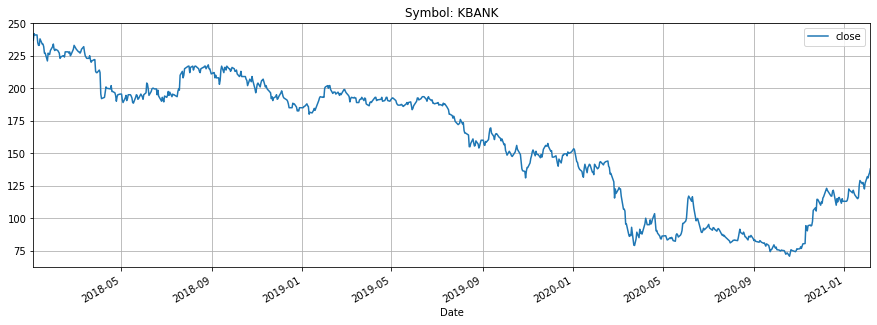

In [14]:
# A quick look at stock price
df.close.plot(figsize=(15,5))
plt.title('Symbol: {}'.format(stock_symbol))
plt.grid()
plt.legend();

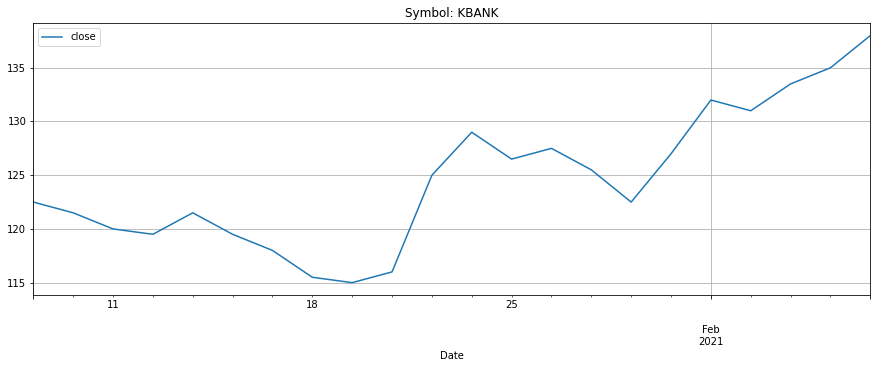

In [15]:
# Zoom to last 1 month
df.iloc[-22:].close.plot(figsize=(15,5))
plt.title('Symbol: {}'.format(stock_symbol))
plt.grid()
plt.legend();

### 1.2 ทำ data cleansing  
เนื่องจากข้อมูลหุ้น ไม่มี null ไม่มี missing data จึงไม่ต้องทำ
แต่หุ้นที่มีการแตกพาร์ เราอาจจะต้องใช้ค่า Adjust Close ย้อนหลังแทนราคา Close ถ้าเราต้องการทำนายแบบไกลๆ  
ในที่นี้เราทำนายแบบระยะสั้นจึงใช้ค่า Close

### 1.3 สร้าง features เพิ่มอีก (feature extraction)
ข้อมูลดิบเรามีแค่ open, high, low, close, volume และ index ต่างๆ เราจะเอา OHLC เอาไปสร้าง features เพิ่มเติม 

### เตรียมฟังก์ชั่นสำหรับสร้าง Feature

In [16]:
# สร้างฟังก์ชั่น Feature Engineer ไว้ใช้งาน 
class FELib:
    """
    Feature Engineering Library
    """

    @staticmethod
    def iif(condition, resultTrue, resultFalse):
        return np.where(condition, resultTrue, resultFalse)

    @staticmethod
    def llv(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).min()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def hhv(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            # series = series.fillna(0)
            result = series.rolling(period, min_periods=1).max()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def ma(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).mean()
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def stdev(series, period):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.rolling(period, min_periods=1).std(skipna=True)
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def ref(series, steps):
        try:
            if type(series) == np.ndarray:
                series = pd.Series(series)
            series = series.fillna(0)
            result = series.shift(steps * -1, fill_value=0.0)
            result = np.nan_to_num(result)
        except Exception as e:
            raise e
        return result

    @staticmethod
    def cur(series):
        if type(series) == np.ndarray:
            series = pd.Series(series)
        series = series.fillna(0)
        result = series[len(series) - 1]
        result = np.nan_to_num(result)
        return result

    @staticmethod
    def llvbars(series, period):
        if type(series) == np.ndarray:
            series = pd.Series(series)
        series = series.fillna(0)
        min_idx = series.index[series.rolling(period).apply(np.argmin, raw=True)[(period - 1):].astype(int) + np.arange(len(series) - (period - 1))]
        out = [0] * len(series)
        out[len(out) - len(min_idx):len(out) + len(min_idx) - 1] = min_idx
        out = np.nan_to_num(out)
        return pd.Series(out)

    @staticmethod
    def hhvbars(series, period):
        if type(series) == np.ndarray:
            series = pd.Series(series)
        series = series.fillna(0)
        max_idx = series.index[series.rolling(period).apply(np.argmax, raw=True)[(period - 1):].astype(int) + np.arange(len(series) - (period - 1))]
        out = [0] * len(series)
        out[len(out) - len(max_idx):len(out) + len(max_idx) - 1] = max_idx
        out = np.nan_to_num(out)
        return pd.Series(out)

    @staticmethod
    def shift(ndarr, period):
        e = np.empty_like(ndarr)
        if period >= 0:
            e[:period] = np.nan
            e[period:] = ndarr[:-period]
        else:
            e[period:] = np.nan
            e[:period] = ndarr[-period:]

        e = np.nan_to_num(e)
        return e

    @staticmethod
    def round_num(series, num):
        result = np.where(series % 1.0 == 0.5, (series + 0.5).round(num), series.round(num))
        return result


In [17]:
# สร้าง Custom Indicator ไว้ใช้งาน ถ้าไม่มีความรู้เทคนิคคอลให้ข้ามส่วนนี้ไปก่อน
import warnings

warnings.simplefilter(action="ignore", category=RuntimeWarning)

class DQIndi():
    # ==============================================================================================================================
    @staticmethod
    def price_channel_code(digits_num, p_high, p_low, period, channel1_val, channel2_val):
        # INDI: Price Channel Code
        HighestHigh = FELib.hhv(p_high, period) * digits_num
        LowestLow = FELib.llv(p_low, period) * digits_num
        HighLowRange = HighestHigh - LowestLow

        channel1 = pd.Series([channel1_val] * len(HighLowRange))
        channel2 = pd.Series([channel2_val] * len(HighLowRange))
        channelColorCode = FELib.iif(HighLowRange <= channel1 \
                                     , 1 \
                                     , FELib.iif((HighLowRange > channel1) & (HighLowRange <= channel2), 2, 3))

        channelColorCode = pd.Series(channelColorCode)
        return channelColorCode

    # ==============================================================================================================================
    @staticmethod
    def sideway_code(digits_num, channel_code, p_close, channel_range1, channel_range2, channel_range3 \
                    , ma, stddev_ma_period, ma_stddev_const, ma_hl_period, ma_close_period1, ma_close_period2):
        # INDI: Sideway Code
        diffLevel = FELib.iif(channel_code == 1, channel_range1 \
                              , FELib.iif(channel_code == 2, channel_range2, channel_range3))

        ma3Stdev = talib.STDDEV(ma, stddev_ma_period) * digits_num

        maStdevLevel = FELib.iif(channel_code == 1, ma_stddev_const \
                                 , FELib.iif(channel_code == 2, ma_stddev_const * 2, ma_stddev_const * 3))

        sidewayCode = FELib.iif((((ma - FELib.llv(ma, ma_hl_period)) * digits_num < diffLevel / 2.5) \
                                | ((FELib.hhv(ma, ma_hl_period) - ma) * digits_num < diffLevel / 2.5)) \
                                & (ma3Stdev < maStdevLevel) \
                                & (abs(ma - talib.SMA(p_close, ma_close_period1)) * digits_num < diffLevel), 2, 1)

        sidewayCode = FELib.iif(abs(talib.EMA(p_close, ma_close_period2) - ma) * digits_num < diffLevel / 2, 2, sidewayCode)
        return sidewayCode

    # ==============================================================================================================================
    @staticmethod
    def trend_code(channel_code, p_close, macd1_short_period, macd1_long_period, macd1_signal_period \
                    , macd2_short_period, macd2_long_period, macd2_signal_period \
                    , macd3_short_period, macd3_long_period, macd3_signal_period \
                    , rolling_period1, rolling_period2, rolling_period3, ma):
        # INDI: Trend Code
        MACDLarge1, MACDSignalLarge1, MACDHist1 = talib.MACD(p_close, macd1_short_period, macd1_long_period, macd1_signal_period)
        if macd2_short_period > 0:
            MACDLarge2, MACDSignalLarge2, MACDHist2 = talib.MACD(p_close, macd2_short_period, macd2_long_period, macd2_signal_period)
        if macd3_short_period > 0:
            MACDLarge3, MACDSignalLarge3, MACDHist3 = talib.MACD(p_close, macd3_short_period, macd3_long_period, macd3_signal_period)

        if macd2_short_period > 0 and macd3_short_period > 0:
            MACDLarge = FELib.iif(channel_code == 1, MACDLarge1, FELib.iif(channel_code == 2, MACDLarge2, MACDLarge3))
            MACDSignalLarge = FELib.iif(channel_code == 1, MACDSignalLarge1 \
                                        , FELib.iif(channel_code == 2, MACDSignalLarge2, MACDSignalLarge3))
        else:
            MACDLarge = MACDLarge1
            MACDSignalLarge = MACDSignalLarge1

        rolling = FELib.iif(channel_code == 1, rolling_period1 \
                            , FELib.iif(channel_code == 2, rolling_period2, rolling_period3))

        trendCode = FELib.iif((ma <= talib.SMA(ma, rolling[0])) & (MACDLarge < MACDSignalLarge) \
                              , 2, FELib.iif((ma <= talib.SMA(ma, rolling[0])) & (MACDLarge >= MACDSignalLarge) \
                                             , 1, FELib.iif((ma >= talib.SMA(ma, rolling[0])) & (MACDLarge > MACDSignalLarge), 4, 3)))
        return trendCode

    # ==============================================================================================================================
    @staticmethod
    def rsi_macd_code(channel_code, p_close, rsi_period, ma_rsi_period \
                    , macd1_short_period, macd1_long_period, macd1_signal_period \
                    , macd2_short_period, macd2_long_period, macd2_signal_period \
                    , macd3_short_period, macd3_long_period, macd3_signal_period):
        # INDI: RSI - MACD Code
        MA_RSI = talib.SMA(talib.RSI(p_close, rsi_period), ma_rsi_period)
        rsiCode = FELib.iif(MA_RSI <= 50 \
                            , FELib.iif(MA_RSI >= talib.SMA(MA_RSI, 10), 1, 2) \
                            , FELib.iif(MA_RSI <= talib.SMA(MA_RSI, 10), 3, 4))

        MACDLarge1, MACDSignalLarge1, MACDHist1 = talib.MACD(p_close, macd1_short_period, macd1_long_period, macd1_signal_period)
        MACDLarge2, MACDSignalLarge2, MACDHist2 = talib.MACD(p_close, macd2_short_period, macd2_long_period, macd2_signal_period)
        MACDLarge3, MACDSignalLarge3, MACDHist3 = talib.MACD(p_close, macd3_short_period, macd3_long_period, macd3_signal_period)

        MACDLarge = FELib.iif(channel_code == 1, MACDLarge1, FELib.iif(channel_code == 2, MACDLarge2, MACDLarge3))
        MACDSignalLarge = FELib.iif(channel_code == 1, MACDSignalLarge1 \
                                        , FELib.iif(channel_code == 2, MACDSignalLarge2, MACDSignalLarge3))

        macdCode = FELib.iif(MACDLarge <= MACDSignalLarge \
                             , FELib.iif(MACDSignalLarge >= 0, 1, 2) \
                             , FELib.iif(MACDSignalLarge < 0, 3, 4))

        rsiMacdCode = FELib.round_num((rsiCode + macdCode) / 2, 0)
        return rsiMacdCode

    # ==============================================================================================================================
    @staticmethod
    def macd_code(p_close, short_period, long_period, signal_period, muliplier):
        # INDI: MACD Code
        MACDSuperLarge, MACDSignalSuperLarge, MACDHistSuperLarge = talib.MACD(p_close \
                                        , short_period, long_period, signal_period)
        MACDSuperLarge = MACDSuperLarge * muliplier
        MACDSignalSuperLarge = MACDSignalSuperLarge * muliplier

        macdSuperLargeCode = FELib.iif(MACDSuperLarge <= MACDSignalSuperLarge \
                                       , FELib.iif(MACDSignalSuperLarge >= 0, 1, 2) \
                                       , FELib.iif(MACDSignalSuperLarge < 0, 3, 4))
        return macdSuperLargeCode

    # ==============================================================================================================================
    @staticmethod
    def atr_code(p_high, p_low, p_close, period, ma_period1, ma_period2, ma_period3, ma_period4 \
            , hl_period, multiplier):
        # INDI: MA - ATR Code
        MA_ATR_Original = talib.EMA(talib.EMA(talib.ATR(p_high, p_low, p_close, period), ma_period1) \
                                    , ma_period2) * multiplier
        MA_ATR = talib.EMA(MA_ATR_Original, ma_period3)

        atrCode = FELib.iif(MA_ATR <= talib.SMA(MA_ATR, ma_period4) \
                            , FELib.iif(MA_ATR != FELib.llv(MA_ATR, hl_period ), 1, 2) \
                            , FELib.iif(MA_ATR != FELib.hhv(MA_ATR, hl_period ), 3, 4))
        return atrCode

    # ==============================================================================================================================
    @staticmethod
    def highlow_zone_code(channel_code, p_close, macd1_short_period, macd1_long_period, macd1_signal_period \
                            , macd2_short_period, macd2_long_period, macd2_signal_period \
                            , macd3_short_period, macd3_long_period, macd3_signal_period \
                            , large_stochd, ma_large_stochd, highlow_upper_zone, highlow_lower_zone):
        # INDI: High / Low Zone Code
        MACDLarge1, MACDSignalLarge1, MACDHist1 = talib.MACD(p_close, macd1_short_period, macd1_long_period, macd1_signal_period)
        if macd2_short_period > 0:
            MACDLarge2, MACDSignalLarge2, MACDHist2 = talib.MACD(p_close, macd2_short_period, macd2_long_period, macd2_signal_period)
        if macd3_short_period > 0:
            MACDLarge3, MACDSignalLarge3, MACDHist3 = talib.MACD(p_close, macd3_short_period, macd3_long_period, macd3_signal_period)

        if macd2_short_period > 0 and macd3_short_period > 0:
            MACDLarge = FELib.iif(channel_code == 1, MACDLarge1, FELib.iif(channel_code == 2, MACDLarge2, MACDLarge3))
            MACDSignalLarge = FELib.iif(channel_code == 1, MACDSignalLarge1 \
                                        , FELib.iif(channel_code == 2, MACDSignalLarge2, MACDSignalLarge3))
        else:
            MACDLarge = MACDLarge1
            MACDSignalLarge = MACDSignalLarge1

        MACDCode = FELib.iif(MACDLarge <= MACDSignalLarge \
                             , FELib.iif(MACDSignalLarge >= 0, 1, 2) \
                             , FELib.iif(MACDSignalLarge < 0, 3, 4))

        MA_Cur_Large_StochD = talib.SMA(large_stochd, ma_large_stochd)

        HighLowZoneCode = FELib.iif((MA_Cur_Large_StochD < highlow_lower_zone) & (MACDCode == 2) \
                                    , 1, FELib.iif((MA_Cur_Large_StochD > highlow_upper_zone) & ((MACDCode == 3) | (MACDCode == 4)), 3, 2))
        return HighLowZoneCode

    # ==============================================================================================================================
    @staticmethod
    def refine_trend_code(p_close, trend_code, channel_code, sideway_code \
                            , ma_short, ma_long, period1, period2, period3):
        # INDI: Refined Trend Code
        trend_code = FELib.iif((trend_code == 4) & (talib.SMA(p_close, period2) < talib.SMA(ma_short, period2)), 3, trend_code)
        trend_code = FELib.iif((trend_code == 4) & (talib.SMA(p_close, period2) < talib.SMA(ma_long, period2)) \
                              & (talib.SMA(p_close, period3) < talib.SMA(ma_short, period3)), 3, trend_code)
        trend_code = FELib.iif((trend_code == 4) & (talib.SMA(p_close, period1) < talib.SMA(ma_long, period1)), 3, trend_code)
        trend_code = FELib.iif((trend_code == 2) & (talib.SMA(p_close, period2) > talib.SMA(ma_short, period2)), 1, trend_code)
        trend_code = FELib.iif((trend_code == 2) & (talib.SMA(p_close, period2) > talib.SMA(ma_long, period2)) \
                              & (talib.SMA(p_close, period3) > talib.SMA(ma_short, period3)), 1, trend_code)
        trend_code = FELib.iif((trend_code == 2) & (talib.SMA(p_close, period1) > talib.SMA(ma_long, period1)), 1, trend_code)

        trend_code = FELib.iif((channel_code == 1) & (sideway_code == 2) & (ma_short < ma_long) & (trend_code == 4), 3, trend_code)
        trend_code = FELib.iif((channel_code == 1) & (sideway_code == 2) & (ma_short > ma_long) & (trend_code == 2), 1, trend_code)
        return trend_code


### 1.3.1 สร้าง feature จาก Stock Indicator ทั่วไป MA, RSI, STOK, STOD, Slope_STOK, Slope_STOD, etc....
### 1.3.2 สร้าง feature Time Series จากการ lag ของ return  lag_ret1, lag_ret2,... จากวันที่ month, day, dayofweek
### 1.3.3 สร้าง feature จาก pattern ของ indicator เช่น ma 5 วันตัด ma 10 วัน,  ราคาปิดตัดเส้น ma 15 วัน, Max_high > MA100, etc...  และจาก custom indicator ที่สร้างเอง
### 1.3.4 สร้าง feature จากดัชนีราคาสินค้าต่างประเทศ หรือในประเทศ
### 1.3.5 สร้าง feature อื่นๆ เช่น web scraping ข่าวหุ้น แล้วแปลงเป็น sentiment บวกหรือลบ หรือดูแท่งเทียน

In [18]:
# สร้างฟังก์ชั่นสร้าง Features เราจะลองสร้าง features ขึ้นมาเยอะๆ แล้วตอนหลังจะดูว่า features ไหนที่มีความสำคัญต่อ model
def extractFeature(df):
    # csv -> dataframe  กรณีใช้ข้อมูลจากไฟล์
    #df = pd.read_csv(price_file)
    df = pd.DataFrame(df, copy=True)
    
#     หลาย indicator ต้องใช้ค่า digits_num ซึ่งหมายถึง จำนวนที่จะคูณราคาแล้วทำให้ราคาระดับ pip เป็นเลขจำนวนเต็ม
#     เพื่อช่วยให้ง่ายในการนำไปคำนวณอื่นๆ ต่อไป
#     เช่น
#         1) GOLD มีราคา 1482.25 และ digits_num มีค่า 10.0
#             ราคา GOLD จะเป็น 1482.25 * digits_num = 14822.5
#         2) EURUSD มีราคา 1.12345 และ digits_num มีค่า 10000.0
#             ราคา EURUSD จะเป็น 1.12345 * digits_num = 11234.5

#     ค่า digits_num ก็คือค่า 10 ยกกำลัง จำนวนหลักทศนิยมสูงสุดของสินค้า ลบด้วย 1
#     เช่น
#         1) GOLD ทั่วไปมีทศนิยม 2 ตำแหน่ง ดังนั้น digits_num มีค่าเท่ากับ 10 ยกกำลัง (2-1) = 10
#         2) EURUSD ทั่วไปมีทศนิยม 5 ตำแหน่ง ดังนั้น digits_num มีค่าเท่ากับ 10 ยกกำลัง (5-1) = 10000
    import math
    digitsNum = 1
    digits = 5 if 'EURUSD' in stock_symbol or 'GBPUSD' in stock_symbol else 1
    digits = 3 if 'USDJPY' in stock_symbol or 'EURJPY' in stock_symbol else digits
    digits = 2 if 'XAUUSD' in stock_symbol or 'GOLD' in stock_symbol else digits
    digitsNum = math.pow(10, (digits - 1))

    # Initial dataframe
    Analytic = pd.DataFrame(df, copy=True)
    arrOpen = df['open'].values
    arrHigh = df['high'].values
    arrLow = df['low'].values
    arrClose = df['close'].values
    #if 'volume' in df.columns or 'VOLUME' in df.columns:
    #    arrVolume = df['volume'].values
    
    # Feature Time Series: Date
    Analytic['month'] = pd.DatetimeIndex(df.index).month 
    Analytic['day'] = pd.DatetimeIndex(df.index).day
    Analytic['dayofweek'] = pd.DatetimeIndex(df.index).dayofweek
    
    # Feature Time Series: Percent Change
    Analytic['Rets'] = df['close']/df['close'].shift(1) - 1
    Nday = p_day
    col_name = []
    for n in range(1,Nday+1):  
        cols = 'Rets Lag'+str(n)
        Analytic[cols] = Analytic['Rets'].shift(n)
        col_name.append(cols)   
    
    # Feature Index: Other market index
    # 1.เราจะใช้ข้อมูล USA วันก่อนหน้า SET ดังนั้นต้อง shift 1 วัน 
    # 2.เราจะใช้ข้อมูล % Change แทนราคา ดังนั้นใช้ pct_change()  ข้อมูลราคาไม่ได้เป็น normal distribution แต่ข้อมูล %change เป็น
    Analytic['nasdaq'] = nasdaq['Close'].shift(1).pct_change()
    Analytic['dow30'] = dow30['Close'].shift(1).pct_change()
    Analytic['sp500'] = sp500['Close'].shift(1).pct_change()
    Analytic['nikkei225'] = nikkei225['Close'].shift(1).pct_change()    
    Analytic['gold'] = gold['Close'].shift(1).pct_change()
    Analytic['oil'] = oil['Close'].shift(1).pct_change()
    Analytic['usdthb'] = usdthb['Close'].shift(1).pct_change()
    
    # Feature Indicator: Moving Average
    Analytic['ma1'] = talib.WMA(arrClose, timeperiod=5)   # WMA 5
    Analytic['ma2'] = talib.EMA(arrClose, timeperiod=10)  # EMA 10
    Analytic['ma3'] = talib.SMA(talib.EMA(arrClose, 14), 2)
    Analytic['ma4'] = talib.EMA(talib.EMA(arrClose, 30), 3)
    Analytic['ma5'] = talib.EMA(talib.EMA(arrClose, 100), 2)
    Analytic['ma6'] = talib.EMA(arrClose, timeperiod=110)  # EMA 110
    Analytic['ma7'] = talib.EMA(arrClose, timeperiod=220)  # EMA 220
    ma3 = Analytic['ma3']
    ma4 = Analytic['ma4']
    ma5 = Analytic['ma5']
    
    # Feature Indicator: RSI
    Analytic['rsi'] = talib.RSI(arrClose, 28)  # RSI 28
    Analytic['rsi_ma'] = talib_abstract.EMA(Analytic, timeperiod=40,price='rsi')  # EMA 40 of RSI 28 #,price='rsi'
    #Analytic['rsi_ma'] = talib.RSI(arrClose, 40).round(decimals=5)
    
    # Feature Indicator: Equivalent
    stochkset1, stochdset1 = talib.STOCH(arrHigh, arrLow, arrClose, 17, 6, 0, 4, 0)  # Slow Stochastics 17,6,4
    stochkset2, stochdset2 = talib.STOCH(arrHigh, arrLow, arrClose, 100, 30, 0,8, 0)  # Slow Stochastics 100,30,8    
    Analytic['stochkset1'] = stochkset1
    Analytic['stochdset1'] = stochdset1
    Analytic['stochkset2'] = stochkset2
    Analytic['stochdset2'] = stochdset2
    
    # Feature Indicator: MACD
    macdset1, macdsignalset1, macdHist1 = talib.MACD(arrClose, 12, 26, 9)  # MACD 12,26,9
    macdset2, macdsignalset2, macdHist2 = talib.MACD(arrClose, 36, 78, 27)  # MACD 36,78,27
    Analytic['macdset1'] = macdset1
    Analytic['macdsignalset1'] = macdsignalset1
    Analytic['macdset2'] = macdset2
    Analytic['macdsignalset2'] = macdsignalset2
    
    # Feature Indicator: BB
    bbtop, bbmid, bbbot = talib.BBANDS(arrClose, 15, 2, 2)  # Bollinger Band 15,2,2  
    Analytic['bbtop'] = bbtop
    Analytic['bbmid'] = bbmid
    Analytic['bbbot'] = bbbot

    # Custom Indicator ที่สร้างจาก Domain Expert  ถ้ายังไม่เก่งเทคนิคคอลให้ข้ามส่วนนี้ไปก่อน  
    #   จะไม่ใช้ features ในส่่วนนี้ก็ได้เพราะ deep learning จะทำ automatic feature extraction ให้
    
    # Feature Custom Indicator: Channel code
    channelColorCode = DQIndi.price_channel_code(digits_num=digitsNum, p_high=arrHigh, p_low=arrLow \
                                                 , period=10, channel1_val=10, channel2_val=20)
    Analytic['channelColorCode'] = channelColorCode.tolist()
    
    # Feature Custom Indicator: Sideway Code
    sidewayCode = DQIndi.sideway_code(digits_num=digitsNum, channel_code=channelColorCode
                                      , p_close=arrClose, channel_range1=2, channel_range2=4
                                      , channel_range3=7, ma=ma3, stddev_ma_period=30
                                      , ma_stddev_const=1, ma_hl_period=12, ma_close_period1=17
                                      , ma_close_period2=2)
    Analytic['sidewayCode'] = sidewayCode.tolist()
    
    # Feature Custom Indicator: Trend Code
    trendCode = DQIndi.trend_code(channel_code=channelColorCode, p_close=arrClose \
                                    , macd1_short_period=120, macd1_long_period=300, macd1_signal_period=90 \
                                    , macd2_short_period=180, macd2_long_period=450, macd2_signal_period=135 \
                                    , macd3_short_period=240, macd3_long_period=600, macd3_signal_period=180 \
                                    , rolling_period1=20, rolling_period2=20, rolling_period3=30, ma=ma3)
    Analytic['trendCode'] = trendCode.tolist()

    # Feature Custom Indicator: RSI - MACD Code
    rsiMacdCode = DQIndi.rsi_macd_code(channel_code=channelColorCode, p_close=arrClose \
                                            , rsi_period=50, ma_rsi_period=80 \
                                            , macd1_short_period=120, macd1_long_period=300, macd1_signal_period=90 \
                                            , macd2_short_period=180, macd2_long_period=450, macd2_signal_period=135 \
                                            , macd3_short_period=240, macd3_long_period=600, macd3_signal_period=180)
    Analytic['rsiMacdCode'] = rsiMacdCode.tolist()
        
    # Feature Custom Indicator: MACD Code
    macdSuperLargeCode = DQIndi.macd_code(p_close=arrClose, short_period=25, long_period=60, signal_period=17, muliplier=10)
    Analytic['macdSuperLargeCode'] = macdSuperLargeCode.tolist()
        
    # Feature Custom Indicator: MA - ATR Code
    atrCode = DQIndi.atr_code(p_high=arrHigh, p_low=arrLow, p_close=arrClose \
                              , period=24, ma_period1=50, ma_period2=20, ma_period3=150 \
                              , ma_period4=10, hl_period=144, multiplier=1000)
    Analytic['atrCode'] = atrCode.tolist()
    
    # Feature Custom Indicator: High / Low Zone Code
    HighLowZoneCode = DQIndi.highlow_zone_code(channel_code=channelColorCode, p_close=arrClose \
                                              , macd1_short_period=120, macd1_long_period=300, macd1_signal_period=90 \
                                              , macd2_short_period=180, macd2_long_period=450, macd2_signal_period=135 \
                                              , macd3_short_period=240, macd3_long_period=600, macd3_signal_period=180 \
                                              , large_stochd=stochdset2, ma_large_stochd=200, highlow_upper_zone=80, highlow_lower_zone=20)
    Analytic['HighLowZoneCode'] = HighLowZoneCode.tolist()

    # Feature Custom Indicator: Refine Indicator
#     trendCode2 = DQIndi.refine_trend_code(p_close=arrClose, trend_code=trendCode, channel_code=channelColorCode \
#                                           , sideway_code=sidewayCode, ma_short=ma3, ma_long=ma4, period1=10
#                                           , period2=50, period3=200)
#     Analytic['trendCode2'] = trendCode2.tolist()

    Analytic['EMA_Close160'] = talib.EMA(arrClose, 160)   
    Analytic['MIN_MA3_10'] = FELib.llv(ma3, 10)
    Analytic['MAX_MA3_10'] = FELib.llv(ma3, 10)
    Analytic['MIN_MA4_50'] = FELib.llv(ma4, 50)
    Analytic['MAX_MA4_50'] = FELib.hhv(ma4, 50)
    Analytic['MIN_MA5_50'] = FELib.llv(ma5, 50)
    Analytic['MAX_MA5_50'] = FELib.llv(ma5, 50)
    Analytic['MIN_MA5_100'] = FELib.llv(ma5, 100)
    Analytic['MAX_MA5_100'] = FELib.llv(ma5, 100)
    
    Analytic['target'] = np.log(df['close'].shift(-Nday)/df['close'])
    # Save data to file
    #Analytic.to_csv(price_indy_file, index=0)
    # Return Features
    return Analytic


In [19]:
minPrice = pd.DataFrame.min(df['close'])
maxPrice = pd.DataFrame.max(df['close'])
minMacd = -10
maxMacd = 10

# Run feature extraction process
# Run create features
priceFeature = extractFeature(df)
priceFeature.fillna(method='ffill', inplace=True)  # fill ค่า NaN ด้วยค่าก่อนหน้า
print(priceFeature.info())
print(priceFeature)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 757 entries, 2018-01-03 to 2021-02-05
Data columns (total 58 columns):
high                  757 non-null float64
low                   757 non-null float64
open                  757 non-null float64
close                 757 non-null float64
volume                757 non-null float64
month                 757 non-null int64
day                   757 non-null int64
dayofweek             757 non-null int64
Rets                  756 non-null float64
Rets Lag1             755 non-null float64
Rets Lag2             754 non-null float64
Rets Lag3             753 non-null float64
Rets Lag4             752 non-null float64
Rets Lag5             751 non-null float64
nasdaq                756 non-null float64
dow30                 756 non-null float64
sp500                 756 non-null float64
nikkei225             753 non-null float64
gold                  756 non-null float64
oil                   756 non-null float64
usdthb                

In [20]:
# สำหรับ drop feature ที่เราไม่สนใจออก
#priceFeature.drop(priceFeature.columns.to_series()["channelColorCode":"macdSuperLargeCode"], axis=1, inplace=True)
#print(priceFeature)

### 1.4 ทำการ Sampling ข้อมูล
* เป็นการเลือกข้อมูลที่มีนัยสำคัญ ในที่นี้คือจุดเข้า order เลือกด้วยเทคนิควิธี Event-Based Sampling แบบ CUSUM
* CUSUM เป็นการ sampling ที่มีการสะสมกำไร (return) แยกตามทิศทางการเปลี่ยนแปลงราคา และมีการหักล้างผลรวม return ของการเปลี่ยนแปลงราคาในทิศทางตรงกันข้าม จะได้ข้อมูลวันที่ที่จะ sampling เราจะเลือกใช้ data เฉพาะวันนั้นๆ
* (reference หนังสือ Advances_in_Financial_Machine_Learning-Wiley, page.38)

In [21]:
# Sampling  (for example Standard Bars, Imbalanced Bars, Runs Bars, Event-Based Sampling) )
#     - use Event-Based Sampling (for example CUSUM, 2sd, Divergence, RSI > 70)
def cusum_filter(series, threshold, ingredient='ret'):
    t_events = []
    if ingredient == 'ret':
        returns = series.pct_change()
    elif ingredient == 'log_ret':
        returns = series.apply(np.log).diff()
    returns = returns.iloc[1:]        # remove first nan
    sum_pos = 0
    sum_neg = 0
    for index, ret in returns.items():
        sum_pos += max(sum_pos + ret, 0)
        sum_neg += max(sum_neg - ret, 0)
        
        if sum_pos > threshold:
            t_events.append(index)
            sum_pos = 0

        if sum_neg > threshold:
            t_events.append(index)
            sum_neg = 0

    return pd.DatetimeIndex(t_events)

In [22]:
# โดยทั่วไปเราจะใช้ Volume Bars แต่เราก็สามารถใช้ bars อื่นๆได้ Time Bars, Tick Bars, Dollar Bars
volume_bars = df
# กำหนด threshold ของ CUSUM return
threshold = 0.001 # manually
#threshold = abs(volume_bars['close'].pct_change(15).mean()) # automatic
print('t=',threshold)
#t_events = cusum_filter(volume_bars['close'], threshold) # incase use sampling bars   ทำ sampling
t_events = volume_bars.index # incase Use all bars, not use sampling  ไม่ทำ sampling

t= 0.001


In [23]:
t_events

DatetimeIndex(['2018-01-03', '2018-01-04', '2018-01-05', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-15', '2018-01-16',
               ...
               '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28',
               '2021-01-29', '2021-02-01', '2021-02-02', '2021-02-03',
               '2021-02-04', '2021-02-05'],
              dtype='datetime64[ns]', name='Date', length=757, freq=None)

 ### 1.5 ทำการ Label ข้อมูลสำหรับ model classification
* มีหลายวิธีการ แต่เลือกใช้ Triple Barrier เพราะสอดคล้องกับ strategy การเทรดจริงของเทรดเดอร์ ที่มีการตั้ง take profit, stop loss และ holding period
* (Reference หนังสือ Advances_in_Financial_Machine_Learning-Wiley, page.45)
* โดยเราจะ label ข้อมูล ตาม sampling โดยสร้าง barrier บน ล่าง ขวา ตามรูป เพื่อเก็บข้อมูลว่าจากจุดที่เข้า sampling แล้วหุ้นจะขึ้นบนขอบขน 
* หรือลงชนขอบล่าง หรือไม่ชนทั้งบนและล่างไปชนขอบขวา(vertical barrier) และเราจะกำหนดขอบขวาที่กราฟ 5 วัน 
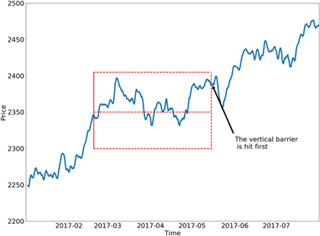
    
* ชนขอบบนให้ label เป็น 1 (up) ชนขอบล่างให้ label เป็น -1 (down) ชนขอบขวาให้ label เป็น 0 (sideway) เอามาใช้ predict ทิศทางของหุ้นหลังจากที่เข้า order

In [24]:
# Labeling (for example Fixed-Time Horizon, Triple Barrier, Trend Scanning)
#     - Use Triple Barrier 
#     - form book Advances_in_Financial_Machine_Learning-Wiley, page.45
#   สร้าง Vertical barrier ด้วย Fixed time Horizon
#     - form book Advances_in_Financial_Machine_Learning-Wiley, page.43
def add_vertical_barrier(t_events, series, num_days=0, num_hours=0, num_minutes=0, num_seconds=0):

    timedelta = pd.Timedelta(f'{num_days} days, {num_hours} hours, {num_minutes} minutes, {num_seconds} seconds')
    # Find index to closest to vertical barrier
    
    nearest_index = series.index.searchsorted(t_events + timedelta)

    # Exclude indexes which are outside the range of close price index
    nearest_index = nearest_index[nearest_index < series.shape[0]]

    # Find price index closest to vertical barrier time stamp
    nearest_timestamp = series.index[nearest_index]
    filtered_events = t_events[:nearest_index.shape[0]]

    vertical_barriers = pd.Series(data=nearest_timestamp, index=filtered_events)
    return vertical_barriers

In [25]:
# กำหนดเวลาในการถือ position ในการสร้าง label   for example 5d   , can be 5m, 1h, 1d, ...
vertical_barriers = add_vertical_barrier(t_events, volume_bars['close'], num_days=p_day)

In [26]:
vertical_barriers

Date
2018-01-03   2018-01-08
2018-01-04   2018-01-09
2018-01-05   2018-01-10
2018-01-08   2018-01-15
2018-01-09   2018-01-15
                ...    
2021-01-25   2021-02-01
2021-01-26   2021-02-01
2021-01-27   2021-02-01
2021-01-28   2021-02-02
2021-01-29   2021-02-03
Name: Date, Length: 752, dtype: datetime64[ns]

In [27]:
# Triple-Barrier คือวิธีการ label ข้อมูลซึ่งสอดคล้องกับ strategy การเทรดของมนุษย์ที่มีการตั้ง take profit, stop loss และ holding period
#  - form book Advances_in_Financial_Machine_Learning-Wiley, page.45
def apply_pt_sl_on_t1(series, events, pt_sl): 

    # Apply stop loss/profit taking, if it takes place before t1 (end of event)
    out = events[['t1']].copy(deep=True)

    profit_taking_multiple = pt_sl[0]
    stop_loss_multiple = pt_sl[1]

    # Profit taking active
    if profit_taking_multiple > 0:
        profit_taking = profit_taking_multiple * events['trgt']
    else:
        profit_taking = pd.Series(index=events.index)  # NaNs

    # Stop loss active
    if stop_loss_multiple > 0:
        stop_loss = -stop_loss_multiple * events['trgt']
    else:
        stop_loss = pd.Series(index=events.index)  # NaNs

    # Get events
    for loc, vertical_barrier in events['t1'].fillna(series.index[-1]).iteritems():
        closing_prices = series[loc: vertical_barrier]  # Path prices for a given trade
        cum_returns = (closing_prices / series[loc] - 1) * events.at[loc, 'side']  # Path returns
        out.loc[loc, 'sl'] = cum_returns[cum_returns < stop_loss[loc]].index.min()  # Earliest stop loss date
        out.loc[loc, 'pt'] = cum_returns[cum_returns > profit_taking[loc]].index.min()  # Earliest profit taking date

    return out

def get_events(series, t_events, pt_sl, target, min_ret, vertical_barrier_times=False, side_prediction=None):

    # 1) Get target
    target = target.loc[t_events]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side_prediction is None:
        side_ = pd.Series(1.0, index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side_prediction.loc[target.index]  # Subset side_prediction on target index.
        pt_sl_ = pt_sl[:2]
    
    # Create a new df with [v_barrier, target, side] and drop rows that are NA in target
    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_}, axis=1)
    events = events.dropna(subset=['trgt'])

    # Apply Triple Barrier
    first_touch_dates = apply_pt_sl_on_t1(series, events, pt_sl_)

    for ind in events.index:
        events.loc[ind, 't1'] = first_touch_dates.loc[ind, :].dropna().min()

    if side_prediction is None:
        events = events.drop('side', axis=1)

    # Add profit taking and stop loss multiples for vertical barrier calculations
    events['pt'] = pt_sl[0]
    events['sl'] = pt_sl[1]

    return events

In [28]:
pt_sl = [1, 1]
min_ret = 0.00001
volatility = volume_bars['close'].rolling(5).std() * 0.1 # multiply for pips or points
triple_barrier_events = get_events(series=volume_bars['close'],
                                   t_events=t_events,
                                   pt_sl=pt_sl,
                                   target=volatility,
                                   min_ret=min_ret,
                                   vertical_barrier_times=vertical_barriers)

In [29]:
triple_barrier_events

t1      trgt  pt  sl
Date                                   
2018-01-09 2018-01-15  0.303315   1   1
2018-01-10 2018-01-15  0.409878   1   1
2018-01-11 2018-01-16  0.409878   1   1
2018-01-12 2018-01-17  0.346410   1   1
2018-01-15 2018-01-22  0.207364   1   1
...               ...       ...  ..  ..
2021-02-01        NaT  0.345326   1   1
2021-02-02        NaT  0.392747   1   1
2021-02-03        NaT  0.445253   1   1
2021-02-04        NaT  0.303315   1   1
2021-02-05        NaT  0.274773   1   1

[753 rows x 4 columns]

In [30]:
# Snippet 3.9, pg 55, Question 3.3
def barrier_touched(out_df, events):

    store = []
    for date_time, values in out_df.iterrows():
        ret = values['ret']
        target = values['trgt']

        pt_level_reached = ret > target * events.loc[date_time, 'pt']
        sl_level_reached = ret < -target * events.loc[date_time, 'sl']

        if ret > 0.0 and pt_level_reached:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and sl_level_reached:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    # Save to 'bin' column and return
    out_df['bin'] = store
    return out_df


# Snippet 3.4 -> 3.7, page 51, Labeling for Side & Size with Meta Labels
def get_bins(triple_barrier_events, series):

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    all_dates = events_.index.union(other=events_['t1'].array).drop_duplicates()
    prices = series.reindex(all_dates, method='bfill')

    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    out_df['target_price'] = prices.loc[events_['t1'].array].array
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret'] = np.log(prices.loc[events_['t1'].array].array) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df, triple_barrier_events)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0

    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1

    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
    
    # bin2: 2 classes -> up & down
    out_df['bin2'] = out_df['ret']
    out_df.loc[out_df['bin2'] >= 0, 'bin2'] = 1
    out_df.loc[out_df['bin2'] <  0, 'bin2'] = -1
    out_df['bin2'] = out_df['bin2'].astype(int)
    
    return out_df

In [31]:
bins = get_bins(triple_barrier_events, volume_bars['close'])

In [32]:
bins  #  output คือได้ bin = (-1,0,1) และ bin2 = (-1,1)  เลือกเอาว่าจะใช้แบบไหน

target_price       ret      trgt  bin  bin2
Date                                                   
2018-01-09         234.0 -0.004255  0.303315    0    -1
2018-01-10         234.0  0.004292  0.409878    0     1
2018-01-11         234.0  0.004292  0.409878    0     1
2018-01-12         232.0 -0.025210  0.346410    0    -1
2018-01-15         221.0 -0.055556  0.207364    0    -1
...                  ...       ...       ...  ...   ...
2021-01-25         132.0  0.043478  0.637966    0     1
2021-01-26         132.0  0.035294  0.513079    0     1
2021-01-27         132.0  0.051793  0.160468    0     1
2021-01-28         131.0  0.069388  0.243926    0     1
2021-01-29         133.5  0.051181  0.198746    0     1

[748 rows x 5 columns]

In [33]:
final_ds = pd.concat([priceFeature, bins], axis=1).reindex(priceFeature.index)
#final_ds.dropna(inplace=True)
final_ds.fillna(method='ffill', inplace=True)

# Save Dataset
#final_ds.to_csv('stock_train.csv')  # in case want to save file

In [34]:
print(final_ds.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 757 entries, 2018-01-03 to 2021-02-05
Data columns (total 63 columns):
high                  757 non-null float64
low                   757 non-null float64
open                  757 non-null float64
close                 757 non-null float64
volume                757 non-null float64
month                 757 non-null int64
day                   757 non-null int64
dayofweek             757 non-null int64
Rets                  756 non-null float64
Rets Lag1             755 non-null float64
Rets Lag2             754 non-null float64
Rets Lag3             753 non-null float64
Rets Lag4             752 non-null float64
Rets Lag5             751 non-null float64
nasdaq                756 non-null float64
dow30                 756 non-null float64
sp500                 756 non-null float64
nikkei225             753 non-null float64
gold                  756 non-null float64
oil                   756 non-null float64
usdthb                

In [35]:
final_ds

high    low   open  close      volume  month  day  dayofweek  \
Date                                                                        
2018-01-03  237.0  233.0  234.0  237.0   6816400.0      1    3          2   
2018-01-04  244.0  238.0  239.0  242.0   8123000.0      1    4          3   
2018-01-05  244.0  240.0  242.0  241.0   6622100.0      1    5          4   
2018-01-08  245.0  241.0  243.0  241.0   8454800.0      1    8          0   
2018-01-09  240.0  234.0  240.0  235.0  13325700.0      1    9          1   
...           ...    ...    ...    ...         ...    ...  ...        ...   
2021-02-01  133.0  127.0  127.5  132.0  33845200.0      2    1          0   
2021-02-02  135.0  130.5  135.0  131.0  22938300.0      2    2          1   
2021-02-03  135.0  132.0  134.0  133.5  30346200.0      2    3          2   
2021-02-04  137.0  132.0  134.5  135.0  23766300.0      2    4          3   
2021-02-05  138.0  136.0  136.5  138.0  17134200.0      2    5          4   

                Rets  Rets Lag1  ...  MIN_MA5_50  MAX_MA5_50  MIN_MA5_100  \
Date                             ...                                        
2018-01-03       NaN        NaN  ...    0.000000    0.000000     0.000000   
2018-01-04  0.021097        NaN  ...    0.000000    0.000000     0.000000   
2018-01-05 -0.004132   0.021097  ...    0.000000    0.000000     0.000000   
2018-01-08  0.000000  -0.004132  ...    0.000000    0.000000     0.000000   
2018-01-09 -0.024896   0.000000  ...    0.000000    0.000000     0.000000   
...              ...        ...  ...         ...         ...          ...   
2021-02-01  0.039370   0.036735  ...   85.047175   85.047175    84.120973   
2021-02-02 -0.007576   0.039370  ...   85.231496   85.231496    84.120973   
2021-02-03  0.019084  -0.007576  ...   85.453680   85.453680    84.120973   
2021-02-04  0.011236   0.019084  ...   85.797513   85.797513    84.120973   
2021-02-05  0.022222   0.011236  ...   86.202957   86.202957    84.120973   

            MAX_MA5_100    target  target_price       ret      trgt  bin  bin2  
Date                                                                            
2018-01-03     0.000000 -0.017022           NaN       NaN       NaN  NaN   NaN  
2018-01-04     0.000000 -0.037899           NaN       NaN       NaN  NaN   NaN  
2018-01-05     0.000000 -0.012526           NaN       NaN       NaN  NaN   NaN  
2018-01-08     0.000000 -0.029476           NaN       NaN       NaN  NaN   NaN  
2018-01-09     0.000000 -0.004264         234.0 -0.004255  0.303315  0.0  -1.0  
...                 ...       ...           ...       ...       ...  ...   ...  
2021-02-01    84.120973  0.083067         133.5  0.051181  0.198746  0.0   1.0  
2021-02-02    84.120973  0.083067         133.5  0.051181  0.198746  0.0   1.0  
2021-02-03    84.120973  0.083067         133.5  0.051181  0.198746  0.0   1.0  
2021-02-04    84.120973  0.083067         133.5  0.051181  0.198746  0.0   1.0  
2021-02-05    84.120973  0.083067         133.5  0.051181  0.198746  0.0   1.0  

[757 rows x 63 columns]

# 2. Modeling
เราจะสร้างหลายๆ model เพื่อเปรียบเทียบกันด้วย ทำเป็น ensemble method  
* 2.1 สร้าง model Classification ด้วย Deep Neural Network เพื่อทำนายทิศทาง
* 2.2 สร้าง model Classification ด้วย XGBoost เพื่อทำนายทิศทาง
* 2.3 สร้าง model Regression ด้วย Deep Neural Network เพื่อทำนายกำไร
* 2.4 สร้าง model Regression ด้วย LSTM เพื่อทำนายกำไร

แบ่ง data train, validation, test, predict สำหรับใช้ใน model

In [36]:
# import ซอฟต์แวร์ไลบรารี่ที่จำเป็น
# - pandas: เป็นเฟรมเวิร์กในการจัดการข้อมูล เราจะใช้มากได้แก่ DataFrame, การเขียน/อ่านไฟล์ข้อมูล
# - sklearn: ชื่อเต็มคือ scikit-learn เป็นเฟรมเวิร์กด้าน Machine Learning (ML) ของ python มีอัลกอริธึมด้าน ML มากมายอยู่ในนี้
# - keras: เป็นเฟรมเวิร์กด้าน Deep Learning ที่ครอบเฟรมเวิร์ก Deep Learning อื่นอีกที โดย Keras ปรับโค้ดให้สั้นและเรียบง่ายขึ้น ช่วยให้เขียนโค้ดง่ายขึ้น ในคอร์สเราใช้ Keras ครอบ TensorFlow หรือเรียกว่า ใช้ TensorFlow เป็น Backend
# - matplotlib: เป็นเฟรมเวิร์กด้าน graph เอาไว้ใช้แสดงผลค่าต่างๆ เป็นกราฟ เช่น ผลการเทรนโมเดล
from pandas import read_csv
from keras.utils import np_utils
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.optimizers import Adagrad
from keras.optimizers import Adamax
from keras.optimizers import RMSprop
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

# fix random seed for reproducibility ช่วยให้การรันแต่ละครั้งได้ผลเหมือนเดิม เพื่อ compare ประสิทธิภาพ model 
seed = 1234
np.random.seed(seed)
#from tensorflow import set_random_seed
#set_random_seed(1234)

Using TensorFlow backend.


In [37]:
# เตรียม data สำหรับการ train
# load dataset
dataframe = final_ds # incase not open file
#dataframe = read_csv("stock_train.csv", header=None) # in case open from file
dataframe = dataframe.iloc[:,:].apply(pd.to_numeric, errors = 'coerce')  # Converting non-numeric values to numeric in some
print(dataframe)

             high    low   open  close      volume  month  day  dayofweek  \
Date                                                                        
2018-01-03  237.0  233.0  234.0  237.0   6816400.0      1    3          2   
2018-01-04  244.0  238.0  239.0  242.0   8123000.0      1    4          3   
2018-01-05  244.0  240.0  242.0  241.0   6622100.0      1    5          4   
2018-01-08  245.0  241.0  243.0  241.0   8454800.0      1    8          0   
2018-01-09  240.0  234.0  240.0  235.0  13325700.0      1    9          1   
...           ...    ...    ...    ...         ...    ...  ...        ...   
2021-02-01  133.0  127.0  127.5  132.0  33845200.0      2    1          0   
2021-02-02  135.0  130.5  135.0  131.0  22938300.0      2    2          1   
2021-02-03  135.0  132.0  134.0  133.5  30346200.0      2    3          2   
2021-02-04  137.0  132.0  134.5  135.0  23766300.0      2    4          3   
2021-02-05  138.0  136.0  136.5  138.0  17134200.0      2    5          4   

In [38]:
#dataframe.dropna(inplace=True) # drop แถวที่มีบางค่าเป็น NaN
#dataset = dataframe.values  # convert pandas to numpy
dataset = dataframe # ไม่ convert เป็น numpy
dataset.fillna(0, inplace=True) # แทนค่า NaN ด้วย 0 บน pandas
#dataset = np.nan_to_num(dataframe , copy=True)  # convert pandas to numpy and convert nan to num
#dataset = dataset[~np.isnan(dataset).any(axis=1)] # แทนค่า NaN ด้วย 0 บน numpy
print('shape of dataset is {}'.format(dataset.shape))
print(dataset) # numpy array

shape of dataset is (757, 63)
             high    low   open  close      volume  month  day  dayofweek  \
Date                                                                        
2018-01-03  237.0  233.0  234.0  237.0   6816400.0      1    3          2   
2018-01-04  244.0  238.0  239.0  242.0   8123000.0      1    4          3   
2018-01-05  244.0  240.0  242.0  241.0   6622100.0      1    5          4   
2018-01-08  245.0  241.0  243.0  241.0   8454800.0      1    8          0   
2018-01-09  240.0  234.0  240.0  235.0  13325700.0      1    9          1   
...           ...    ...    ...    ...         ...    ...  ...        ...   
2021-02-01  133.0  127.0  127.5  132.0  33845200.0      2    1          0   
2021-02-02  135.0  130.5  135.0  131.0  22938300.0      2    2          1   
2021-02-03  135.0  132.0  134.0  133.5  30346200.0      2    3          2   
2021-02-04  137.0  132.0  134.5  135.0  23766300.0      2    4          3   
2021-02-05  138.0  136.0  136.5  138.0  171342

In [39]:
# split into input and output variables (split column)
#X = dataset.iloc[:,5:-5].astype(float)   # data train and test,  เรียกแบบ column index
X = dataset.loc[:,'month':'MAX_MA5_100'].astype(float)   # เรียกแบบ column name

# กำหนด label สำหรับ model classification
#Y = dataset.iloc[:,-1]                   # bin2 lebel for up(1)/down(-1)
Y = dataset.loc[:,'bin2'] 
#Y = dataset[:,-2]                  # bin1 lebel for up(1)/down(-1)/sideway(0)
#Y = np.nan_to_num(Y , copy=True)

# กำหนด label สำหรับ model regression  ฟิลด์นี้ต้องเลือกตำแหน่งคอลัมภ์เอง
#Z = dataset.iloc[:,-6].astype(float)      # target return profit (this case predict return next 5 days)
Z = dataset.loc[:, 'target'].astype(float)    # เรียกแบบ column name  
#Z = dataset[:,-5].astype(float)    # ใช้ close price ในการทำนาย (this case predict close price next 5 days)

print(X)
print(Y)
print(Z)

            month  day  dayofweek      Rets  Rets Lag1  Rets Lag2  Rets Lag3  \
Date                                                                           
2018-01-03    1.0  3.0        2.0  0.000000   0.000000   0.000000   0.000000   
2018-01-04    1.0  4.0        3.0  0.021097   0.000000   0.000000   0.000000   
2018-01-05    1.0  5.0        4.0 -0.004132   0.021097   0.000000   0.000000   
2018-01-08    1.0  8.0        0.0  0.000000  -0.004132   0.021097   0.000000   
2018-01-09    1.0  9.0        1.0 -0.024896   0.000000  -0.004132   0.021097   
...           ...  ...        ...       ...        ...        ...        ...   
2021-02-01    2.0  1.0        0.0  0.039370   0.036735  -0.023904  -0.015686   
2021-02-02    2.0  2.0        1.0 -0.007576   0.039370   0.036735  -0.023904   
2021-02-03    2.0  3.0        2.0  0.019084  -0.007576   0.039370   0.036735   
2021-02-04    2.0  4.0        3.0  0.011236   0.019084  -0.007576   0.039370   
2021-02-05    2.0  5.0        4.0  0.022

In [40]:
# standardize dataset
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler().fit(X)
#X = scaler.transform(X)

# Rescale Data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)
print(X)   # X กลายเป็น numpy array

# Normalize Data
#from sklearn.preprocessing import Normalizer
#scaler = Normalizer().fit(X)
#X = scaler.transform(X)

[[0.00000 0.06667 0.50000 ... 0.00000 0.00000 0.00000]
 [0.00000 0.10000 0.75000 ... 0.00000 0.00000 0.00000]
 [0.00000 0.13333 1.00000 ... 0.00000 0.00000 0.00000]
 ...
 [0.09091 0.06667 0.50000 ... 0.40909 0.40943 0.40943]
 [0.09091 0.10000 0.75000 ... 0.41074 0.40943 0.40943]
 [0.09091 0.13333 1.00000 ... 0.41268 0.40943 0.40943]]


In [41]:
# กำหนด train data ในที่นี้เราใช้ validation ใน train เป็น test data
# Split X to train and test  (split row)
X_train = X[:-45,:] # data train and validation
X_test = X[-45:-p_day,:] # unseen data test or predict
X_last = X[-p_day:,:] # unseen data

Y_train = Y[:-45,]
Y_test = Y[-45:-p_day,]
Y_last = Y[-p_day:,] # unseen future prediction

Z_train = Z[:-45,]
Z_test = Z[-45:-p_day,]
Z_last = Z[-p_day:,] # unseen future prediction

In [42]:
# convert labels to categorical one-hot encoding  แปลง Y เป็น one hot label
# ### เข้ารหัสข้อมูล แบบ One Hot Encoder
# เนื่องจากข้อมูลขนิด class หรือ ประเภท ไม่ว่าเป็นตัวเลขหรือคำนาม ในตอนเทรนโมเดลจะทำให้อัลกอริธึมเข้าใจยาก จึงควรแปลงฟอร์แมตด้วยการเข้ารหัสให้เป็นตัวเลขในรูปแบบ 0 กับ 1 ก่อน
# เช่น "BUY" = 100, "SELL" = 010, "NONE" = 001
# พารามิเตอร์ num_classes เป็นการระบุจำนวน class ในตัวอย่างคือ 3
encoder = LabelEncoder()
encoder.fit(Y_train)
encoded_Y = encoder.transform(Y_train)
one_hot_labels = np_utils.to_categorical(encoded_Y, num_classes=3)
print("num_classes = ", len(one_hot_labels[0]))
print(one_hot_labels[0])
print(one_hot_labels[6])

num_classes =  3
[0.00000 1.00000 0.00000]
[0.00000 0.00000 1.00000]


## 2.1 สร้าง model Classification ด้วย Deep Neural Network เพื่อทำนายทิศทาง
เลือกใช้ model deep neural network เพราะข้อมูลหุ้นซับซ้อนมาก เป็น non-linear และมี noise ที่เป็น bias เยอะมาก ตัวอย่าง Deep Learning ชนิด Deep Neural Network หรือเรียกอีกชื่อคือ Multi-Layered Perceptron (MLP) เป็น neural network ที่มีชั้น hidden layer หลายชั้น ปกติ neural network เฉยๆมีชั้น hidden layer เพียงชั้นเดียว ที่เติม 'Deep' ไปข้างหน้าเพื่อบ่งบอกว่าเป็น neural network ที่มีชั้น hidden layer หลายชั้นนั่นเอง 
การมีชั้น hidden layer หลายชั้น ทำให้สามารถประมวลผลซับซ้อนขึ้น ได้มากกว่าแบบมีชั้นเดียว 
เมื่อเรา train model DDN จะเกิดการปรับ weight ที่ node ไป/กลับ คือการทำ feedforward และ backpropagation
### 2.1.1 สร้าง model
ในตัวอย่างเป็นการสร้างฟังก์ชั่นชื่อ `create_model` สำหรับสร้างโมเดล
  - input layer มีจำนวน neuron(node) = จำนวน features
  - output layer มีจำนวน neuron(node) ทั้งหมด 3 neuron ซึ่งต้องมีจำนวนตรงกับจำนวนคลาสจริงๆ (up, down, sideway) หรือ (buy, sell, none)
  - hidden layer ในตัวอย่างมี 3 hidden layer โดยเลเยอร์ที่ 1,2,3 มี 32 neuron(node) 
  - ในแต่ละเลเยอร์ได้กำหนด `activation function` เหมือนหรือต่างกันได้ ตัวที่นิยมคือ `relu` 
  - เมื่อกำหนดรายละเอียดเลเยอร์ทั้งหมดเสร็จแล้ว ก็ต้อง compile ซึ่งเป็นการตรวจสอบรายละเอียดที่ได้สร้างโมเดลไปนั่นเอง และเป็นการเติมรายละเอียดที่จำเป็นเข้าไปในโมเดล ในตัวอย่างได้แก่
  - loss หมายถึง `loss function` ที่ใช้ ในตัวอย่างใช้ `mse` 
      - ซึ่งในกรณีที่เป็นปัญหาแบบ `multiclass classification` ควรใช้ `loss function` แบบ `categorical_crossentropy`
  - optimizer หมายถึง `optimization` ที่ใช้สำหรับการทำ `backproppagation` ในตัวอย่างใช้ `adam`
  - metrics หมายถึง กำหนดค่าผลการเทรนโมเดลที่ต้องการดู ในตัวอย่างใช้ `accuracy` ซึ่ง metrics นี้ไม่มีผลต่อการสร้างและเทรนโมเดล

    *หากต้องการใช้กับเครื่องที่มีการ์ดจอหลายตัว ให้เอาคอมเม้นต์ในบรรทัด #model = make_parallel(model, 3) ออก
    ค่า 3 หมายถึงจำนวนการ์ดจอที่มีในเครื่อง 3 ตัว

In [43]:
# create model classsification
def create_model():  # for tune param ex. activation='relu', neurons=32, optimizer='adam',learn_rate=0.0001, momentum=0,init_mode='uniform',dropout_rate=0.0
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='sigmoid', activity_regularizer=l2(0.0001), kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', activity_regularizer=l2(0.0001), kernel_constraint=maxnorm(3)))    
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='tanh', activity_regularizer=l2(0.0001), kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax',  activity_regularizer=l2(0.0001))) # kernel_initializer=init_mode
    # Make parallel using multi-gpu
    #model = make_parallel(model, 3)
    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #optimizer = SGD(lr=0.02, momentum=0.0, decay=0.01, nesterov=True)
    # optimizer = Adadelta(lr=2.0, rho=0.99, epsilon=1e-08, decay=0.0)  
    #optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-07)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#### Evaluate model ด้วย K-Fold Cross Validation
* เสริมการ evaluate model ด้วยการทำ KFold cross validaiton เพื่อไม่ให้ Model overfitting กับช่วงใดช่วงหนึ่ง (ใน production เราจะ save model และ weight ของการ training ลงไฟล์จะได้ไม่เสียเวลา train ใหม่ และเรียกใช้โดยการอ่าน model ที่ save ขึ้นมา predict)
* KFold cross validation ใช้เป็นแบบ `StratifiedKFold` เพราะเหมาะกับปัญหาที่มีจำนวนคลาสไม่สมดุลกัน (เช่นมี Up มากกว่า Down)
* ในตัวอย่างนี้เป็นการใช้ for loop เพื่อวนลูปจำนวน 5 รอบเท่ากับจำนวน fold เพื่อแสดงให้เห็นว่าในแต่ละรอบของการเทรน สามารถปรับค่าพารามิเตอร์ให้แตกต่างกันได้ (แต่ในตัวอย่างนี้ไม่ได้ปรับ)
* นอกจากนี้ยังสามารถเล่นกับการใช้ GPU (การ์ดจอ) ได้ เพราะแต่ละรอบคือการสร้างโมเดลใหม่ หรือจริงๆ ก็คือการสร้าง 5 โมเดลนั่นเอง ทำให้สามารถส่งแต่ละโมเดลไปรันบน GPU ต่างๆ ได้ เช่น ถ้าในเครื่องมี GPU 2 ตัว ก็แบ่งโมเดลเป็น 2 ส่วน ส่วนละ 3 โมเดล แล้วส่งโมเดลแต่ละส่วนไปรันบน GPU คนละตัวกัน แล้วค่อยนำค่า score มาคำนวณ score เฉลี่ยในขั้นตอนสุดท้ายก็ได้
* ใน for loop มีขั้นตอนหลักคือ 1) สร้างโมเดล 2) เทรนโมเดล 3) ประเมิลผลการเทรนเป็นคะแนน (score)
* ในขั้นตอนเทรนโมเดลใช้ฟังก์ชั่น `fit` โดยส่งค่า `X_train[train]` หมายถึง input, `one_hot_labels[train]` หมายถึง output หรือคอลัมน์ที่เป็น label นั่นเอง, `epochs` หมายถึงจำนวนรอบสูงสุดในการเทน, `batch_size` หมายถึงจำนวนชุดข้อมูลต่อการปรับ weight หนึ่งครั้ง เช่น batch_size=128 หมายถึงเทรนข้อมูลทีละจำนวน 128 ชุดจนเสร็จแล้วค่อยปรับ weight ส่วนพารามิเตอร์สุดท้ายคือ `verbose` ถ้าเซ็ตค่าเป็น `1` หมายถึงให้แสดงผลการเทรนแต่ละรอบผ่านทางหน้าจอ ถ้าเซ็ตเป็นค่า `0` จะไม่แสดงผลอะไร หากใช้เวลาเทรนนาน อาจนึกว่าโปรแกรมแฮงก์ได้ :)
* ในแต่ละรอบของ for loop จะได้ค่า accuracy โดยเมื่อเทรนครบ 5 รอบแล้วจะนำค่า accuracy ทั้ง 5 ค่ามาหาค่าเฉลี่ย และ standard deviation แล้วแสดงบนหน้าจอ

In [44]:
# evaluate model ด้วย KFold cross validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)  # แบ่งข้อมูลเป็น 5 ส่วน สลับกันเทรน
cvscores = []  
for train, test in kfold.split(X_train, Y_train):
    # create model
    model = create_model()
    # fit the model     
    history = model.fit(X_train[train], one_hot_labels[train], validation_split=0.33, epochs=200, batch_size=128, verbose=1)
    # evaluate the model     
    scores = model.evaluate(X_train[test], one_hot_labels[test], verbose=1)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)
# filename = stock_symbol +"_C.h5"
# model.save(filename)   

p - loss: 0.8464 - acc: 0.4304 - val_loss: 0.7840 - val_acc: 0.5397
Epoch 55/200
381/381 [==============================] - 0s 60us/step - loss: 0.8402 - acc: 0.4672 - val_loss: 0.7827 - val_acc: 0.5397
Epoch 56/200
381/381 [==============================] - 0s 84us/step - loss: 0.8378 - acc: 0.4934 - val_loss: 0.7812 - val_acc: 0.5397
Epoch 57/200
381/381 [==============================] - 0s 79us/step - loss: 0.8481 - acc: 0.4724 - val_loss: 0.7803 - val_acc: 0.5397
Epoch 58/200
381/381 [==============================] - 0s 74us/step - loss: 0.8385 - acc: 0.4882 - val_loss: 0.7791 - val_acc: 0.5397
Epoch 59/200
381/381 [==============================] - 0s 87us/step - loss: 0.8275 - acc: 0.4961 - val_loss: 0.7779 - val_acc: 0.5397
Epoch 60/200
381/381 [==============================] - 0s 194us/step - loss: 0.8337 - acc: 0.4882 - val_loss: 0.7769 - val_acc: 0.5397
Epoch 61/200
381/381 [==============================] - 0s 121us/step - loss: 0.8165 - acc: 0.5302 - val_loss: 0.7763 - v

In [45]:
print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[1], numpy.mean(cvscores), numpy.std(cvscores)))

acc: 51.40% (+/- 0.74%)


พล็อตกราฟ loss และกราฟ accuracy ของ data train/validation ดู เพื่อกลับไปปรับปรุง model ไม่ให้เกิดการ overfit หรือ underfit ของ model 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


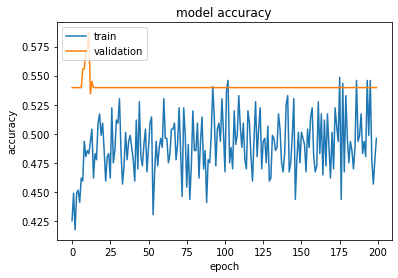

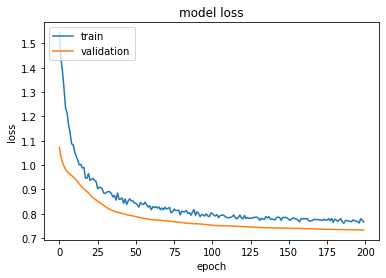

In [46]:
def show_graph(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
show_graph(history)

### 2.1.2 Grid Search Hyperparameters - KerasClassifier
tune model ด้วยการทำ grid search optimization เพื่อปรับ hyperparameter ของ neural network ให้ได้ accuracy ที่มากที่สุด

ตัวอย่างการจูน hyperparameter ต่างๆ ใน Deep Neural Network เพื่อหาค่าพารามิเตอร์ที่ดีที่สุด โดยการเทรนและทดสอบจะรันแบบอัตโนมัติ จะได้ไม่ต้องเสียเวลามาปรับค่าพารามิเตอร์แบบ manual เอง แต่การใช้ Grid Search Hyperparameters จะใช้เวลาในการรันนานมาก เพราะจะทำการทดสอบกับค่าพารามเตอร์ทุกค่าที่กำหนด เช่น กำหนด batch_size 3 ค่า และ epochs 3 ค่า จะต้องรันทั้งสิ้น 3 x 3 = 9 ครั้ง

In [47]:
# # uncomment for tune hyperparameters
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier
# seed = 1234
# numpy.random.seed(seed)
# # create model
# model = KerasClassifier(build_fn=create_model, verbose=1)
# # define the grid search parameters
# batch_size = [32, 64, 128, 256, 300, 512]
# epochs = [50, 100, 150, 200]
# optimizer = ['rmsprop', 'adam', 'adamax', 'sgd', 'adagrad']
# learn_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
# momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# activation1 = ['relu', 'tanh', 'sigmoid', 'linear']
# activation2 = ['relu', 'tanh', 'sigmoid', 'linear']
# activation3 = ['relu', 'tanh', 'sigmoid', 'linear']
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
# weight_constraint = [1, 2, 3, 4, 5]
# neurons = [32, 64, 256]
# neurons2 = [32, 64, 128, 256]
# neurons3 = [32, 64, 256]

# param_grid = dict(batch_size=batch_size,epochs=epochs)

# kfold_splits = 3
# grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold_splits, n_jobs=-1)
# grid_result = grid.fit(X_train, one_hot_labels)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


### 2.1.3 KerasClassifier Feature Importance
รัน feature importance เพื่อดูว่า feature ไหนที่มีอิทธิพลต่อ model KerasClassifier บ้าง

Epoch 1/1
712/712 [==============================] - 1s 2ms/step - loss: 1.2303 - acc: 0.4284
Feature: 0, Score: 0.00000, Name: month
Feature: 1, Score: 0.00000, Name: day
Feature: 2, Score: 0.00000, Name: dayofweek
Feature: 3, Score: 0.00000, Name: Rets
Feature: 4, Score: 0.00000, Name: Rets Lag1
Feature: 5, Score: 0.00000, Name: Rets Lag2
Feature: 6, Score: 0.00000, Name: Rets Lag3
Feature: 7, Score: 0.00000, Name: Rets Lag4
Feature: 8, Score: 0.00000, Name: Rets Lag5
Feature: 9, Score: 0.00000, Name: nasdaq
Feature: 10, Score: 0.00000, Name: dow30
Feature: 11, Score: 0.00000, Name: sp500
Feature: 12, Score: 0.00000, Name: nikkei225
Feature: 13, Score: 0.00000, Name: gold
Feature: 14, Score: 0.00000, Name: oil
Feature: 15, Score: 0.00000, Name: usdthb
Feature: 16, Score: 0.00000, Name: ma1
Feature: 17, Score: 0.00000, Name: ma2
Feature: 18, Score: 0.00000, Name: ma3
Feature: 19, Score: 0.00000, Name: ma4
Feature: 20, Score: 0.00000, Name: ma5
Feature: 21, Score: 0.00000, Name: ma6
Fe

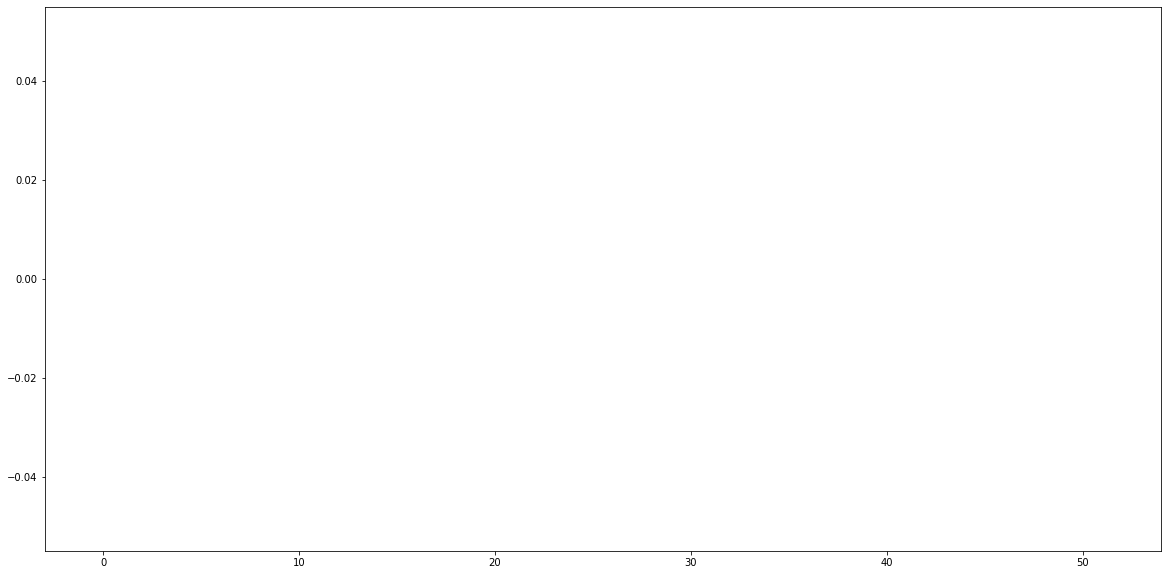

In [48]:
# Method 1  use lib sklearn permutation_importance
from sklearn.inspection import permutation_importance
#seed = 1234
#numpy.random.seed(seed)
#import sklearn.inspection
wrapper_model = KerasClassifier(build_fn=create_model)
# fit the model
wrapper_model.fit(X_train, Y_train) #scikit learn only take 2D input here
# perform permutation importance
results = permutation_importance(wrapper_model, X_train, Y_train, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f, Name: %s' % (i,v,final_ds.columns[5:-6][i]))
# plot feature importance
plt.figure(figsize=(20, 10))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [49]:
# Method 2  use lib eli5 PermutationImportance
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

my_model = KerasClassifier(build_fn=create_model)    
my_model.fit(X_train, one_hot_labels)

perm = PermutationImportance(my_model, random_state=1).fit(X_train, one_hot_labels)
eli5.show_weights(perm, feature_names = final_ds.columns[5:-6].tolist(), top=100)

Epoch 1/1
712/712 [==============================] - 0s 51us/step


### 2.1.4 Test Set Classification Accuracy
ทดสอบโมเดลกับ test dataset ซึ่งควรใช้เป็น out sample data
โค้ดด้านล่างเป็นการโหลด test dataset แล้วทดสอบด้วยการเรียกฟังก์ชั่น `predict`
ในตัวอย่างเมื่อ `predict` เสร็จแล้วจะได้ผลลัพธ์เป็นรหัส `one hot encoding` ซึ่งจะต้องแปลงข้อมูลจาก `one hot encoding` กลับมาเป็น -1, 1 โดยเรียกใช้ฟังก์ชั่น `inverse_transform` 

In [50]:
from sklearn.metrics import accuracy_score
# filename = stock_symbol +"_C.h5"
# model = load_model(filename)
# calculate predictions
#predictions = model.predict(X_test[:,0:X_test.shape[1]],)
predictions = model.predict(X_test,)
predicted_labels1 = encoder.inverse_transform(np.argmax(predictions,1))
print('predict 1 (up) -1 (down) 0 (sideway)')
print(predicted_labels1.astype(int).tolist())
print(Y_test.astype(int).to_list())
#numpy.savetxt("stock_labels.txt", predicted_labels1, fmt='%s')
acc_dnn = accuracy_score(Y_test,predicted_labels1) * 100.0
print('Accuracy: %.2f%%' % acc_dnn)
# ในตัวอย่าง ไม่ได้สร้าง label ที่มีค่า 0 sideway

predict 1 (up) -1 (down) 0 (sideway)
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1]
Accuracy: 47.50%


## 2.2 สร้าง model Classification ด้วย XGBoost เพื่อทำนายทิศทาง
* XGBoost ประยุกต์มาจาก Gradient Boosted Trees ที่ใช้การ generate decisiton tree จำนวนมากๆ แล้ว optimize การสร้าง tree ไปด้วยพร้อมๆ กัน XGBoost ย่อมาจากคำว่า `eXtreme Gradient Boosting` XGBoost มีความโดดเด่นในด้านการ optimize การสร้าง tree และความเร็วในการทำงาน เพราะสามารถกำหนดจำนวน thread ให้มีหลายๆ thread ทำงานพร้อมกันในเครื่องเดียว (ขึ้นกับซีพียูด้วยว่ามีกี่ core และรองรับ thread สูงสุดได้เท่าไร) และยังรองรับการประมวลผลแบบกระจายไปในหลายๆ เครื่องพร้อมๆ กัน โดยทำงานร่วมกับ Apache Spark ทำให้ยิ่งสร้าง tree จำนวนมากเสร็จในเวลาอันสั้นยิ่งขึ้น
* ในปัจจุบัน XGBoost ถือเป็นอัลกอริธึมที่ได้รับความนิยมสูงมากพอๆ กับ Deep Learning เพราะมีความแม่นยำสูง และยังใช้เวลาเทรนโมเดลสั้นมากๆ
* นอกจากนี้ยังสามารถเล่นกับการใช้ GPU (การ์ดจอ) ได้ เพราะแต่ละรอบคือการสร้างโมเดลใหม่ หรือจริงๆ ก็คือการสร้าง 10 โมเดลนั่นเอง ทำให้สามารถส่งแต่ละโมเดลไปรันบน GPU ต่างๆ ได้ เช่น ถ้าในเครื่องมี GPU 2 ตัว ก็แบ่งโมเดลเป็น 2 ส่วน ส่วนละ 5 โมเดล แล้วส่งโมเดลแต่ละส่วนไปรันบน GPU คนละตัวกัน แล้วค่อยนำค่า score มาคำนวณ score เฉลี่ยในขั้นตอนสุดท้ายก็ได้ (n_jobs=1)

### 2.2.1 สร้าง model

In [51]:
# Import libraries
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

seed = 1234
modelC2 = XGBClassifier(max_depth=6, n_estimators=100, random_state=seed
                      , n_jobs=1, learning_rate=0.1)

In [52]:
# แบบไม่ใช้ KFold
# from sklearn.model_selection import train_test_split
# X_train_XGB, X_val, Y_train_XGB, Y_val = train_test_split(X_train, Y_train
#                                         , test_size=0.33, random_state=seed)
# eval_set = [(X_train_XGB, Y_train_XGB), (X_val, Y_val)]

# modelC2.fit(X_train_XGB, Y_train_XGB, early_stopping_rounds=15
#           , eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=True)

# Y_val_predict = modelC2.predict(X_val)
# score = accuracy_score(Y_val, Y_val_predict) * 100.0
# print('score : %.2f%%' % score)
# cvscores.append(score)
# print("Accuracy: %.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

# results = modelC2.evals_result()

* ทำ KFold Cross Validation กำหนดจำนวน fold เท่ากับ 10(n_splits=10)
* KFold cross validation ใช้เป็นแบบ StratifiedKFold เพราะเหมาะกับปัญหาที่มีจำนวนคลาสไม่สมดุลกัน (เช่นมี down มากกว่า up) แสดงผลเป็นค่า Accuracy โดยวิธีนำผลจากการทดสอบทุก fold (10) มาเฉลี่ยกัน แล้วคูณด้วย 100 เพื่อแสดงค่าเป็น % และแสดงค่า standard deviation จากการทดสอบทุกรอบ (ค่า standard deviation ยิ่งต่ำยิ่งดี แสดงว่าโมเดลมีความ robust สูง -> variance ต่ำ แล้วถ้าผล accuracy ออกมาดีด้วย ยิ่งทำให้ bias ไม่สูง ซึ่งถือว่าดี) ในตัวอย่างนี้เป็นการใช้ for loop เพื่อวนลูปจำนวน 10 รอบเท่ากับจำนวน fold เพื่อแสดงให้เห็นว่าในแต่ละรอบของการเทรน สามารถปรับค่าพารามิเตอร์ให้แตกต่างกันได้ (แต่ในตัวอย่างนี้ไม่ได้ปรับ)
* ฟังก์ชั่น fit คือการสั่งเทรนโมเดล ฟังก์ชั่น predict คือการทดสอบโมเดลกับข้อมูล out sample data ในการนำโมเดลไปใช้งานจริงก็ใช้ฟังก์ชั่น predict เช่นกัน
* model นี้ไม่ได้แปลง label เป็น one hot แต่ใช้ label เป็นแบบ multi-class เลย

In [53]:
# Train model
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
i = 1
for train, test in kfold.split(X_train, Y_train):
    eval_set = [(X_train[train], Y_train[train]), (X_train[test], Y_train[test])]
    # Fit the model
    # for multi-class use mlogloss, for binary use logloss
    modelC2.fit(X_train[train], Y_train[train], early_stopping_rounds=10
               , eval_metric=["merror", "mlogloss"], eval_set=eval_set, verbose=False)
    # evaluate the model
    predicted_result = modelC2.predict(X_train[test])
    score = accuracy_score(Y_train[test], predicted_result) * 100.0
    results = modelC2.evals_result()
    print('score round ', i, ' : %.2f%%' % score)
    cvscores.append(score)
    i = i + 1
print("Accuracy: %.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

score round  1  : 73.61%
score round  2  : 66.67%
score round  3  : 71.83%
score round  4  : 74.65%
score round  5  : 69.01%
score round  6  : 66.20%
score round  7  : 81.69%
score round  8  : 74.65%
score round  9  : 71.83%
score round  10  : 78.87%
Accuracy: 72.90% (+/- 4.70%)


พล็อตกราฟ learning curve loss และกราฟ error ดู เพื่อกลับไปปรับปรุง model ไม่ให้เกิดการ overfit หรือ underfit ของ model

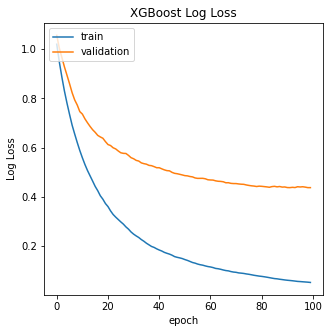

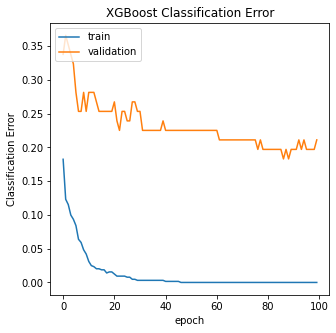

In [54]:
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')  
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
plt.title('XGBoost Log Loss')
plt.ylabel('Log Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x_axis, results['validation_0']['merror'], label='Train')  
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
plt.title('XGBoost Classification Error')
plt.ylabel('Classification Error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 2.2.2 Grid Search Hyperparameter - XGBoost

In [55]:
# from sklearn.model_selection import GridSearchCV

# max_depth = [3, 5, 6]
# n_estimators = [100, 150, 200]
# learning_rate = [0.05, 0.1]
# param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# grid_search = GridSearchCV(modelC2, param_grid, scoring='neg_mean_squared_error'
#                            , n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(X_train, Y_train)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))

### 2.2.3 XGBoost Feature Importance
ดู features ที่มีอิทธิพลต่อ model เรียงลำดับไป

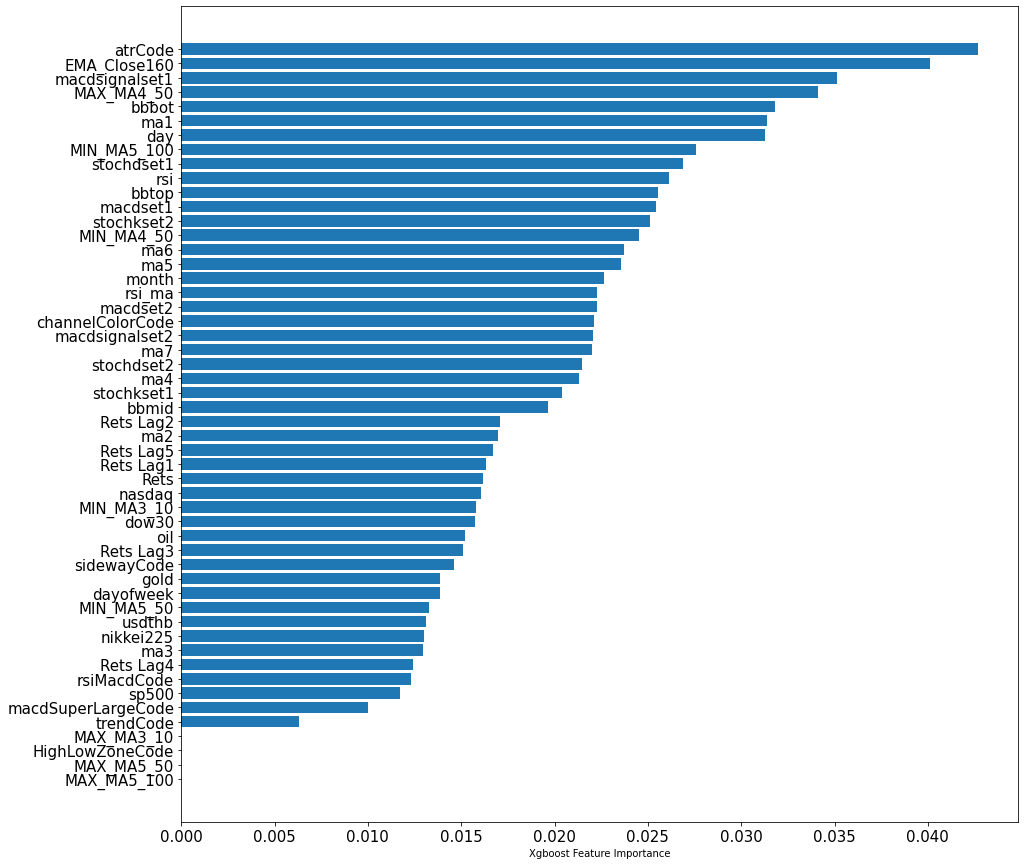

In [56]:
# method 1  ใช้ build-in function ของ xgboost
feature_names = final_ds.columns[5:-6]  # ถ้าไม่กำหนด จะได้ feature name เป็น ff..
sorted_idx = modelC2.feature_importances_.argsort()
plt.figure(figsize=(15,15))
plt.barh(feature_names[sorted_idx], modelC2.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.yticks(fontsize=15) 
plt.xticks(fontsize=15) 
plt.show()
# หุ้นแต่ละตัวจะมี feature importance ที่ต่างกัน

(array([-0.00750, -0.00500, -0.00250, 0.00000, 0.00250, 0.00500, 0.00750,
        0.01000, 0.01250, 0.01500, 0.01750]),
 <a list of 11 Text major ticklabel objects>)

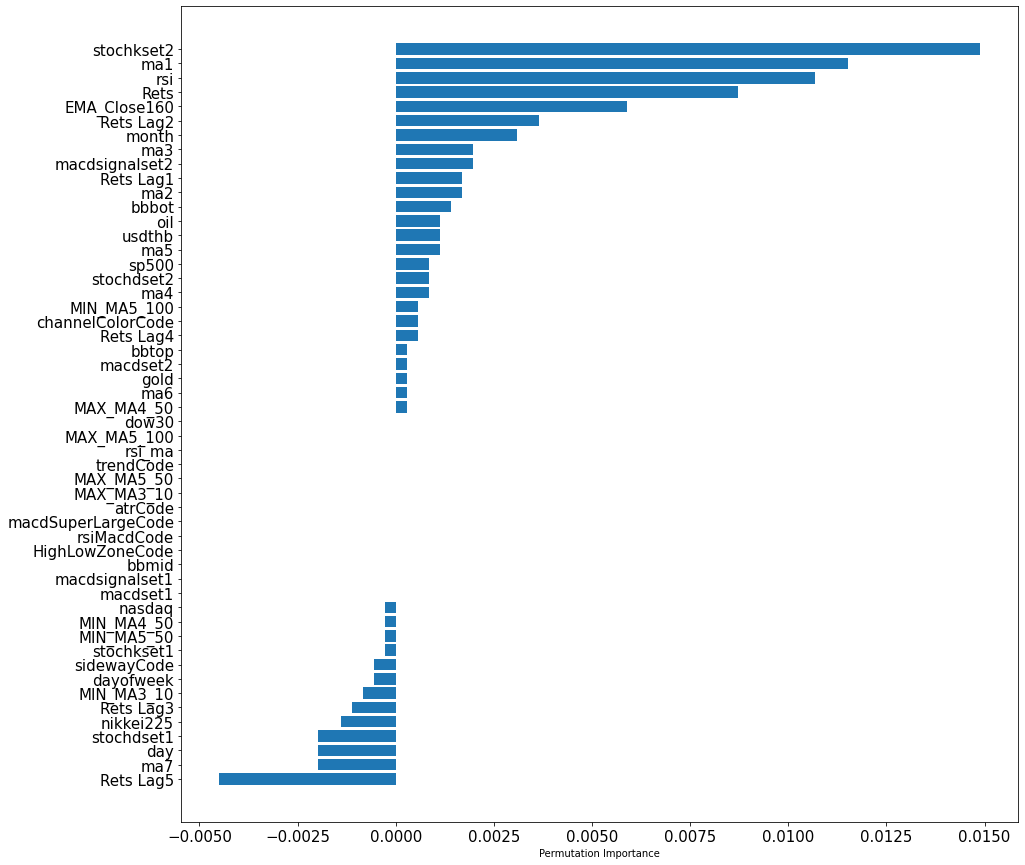

In [57]:
# method 2  ใช้ function permutation_importance ครอบจักรวาลของ sklearn 
perm_importance = permutation_importance(modelC2, X_train, Y_train)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(15,15))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.yticks(fontsize=15) 
plt.xticks(fontsize=15) 
# หุ้นแต่ละตัวจะมี feature importance ที่ต่างกัน

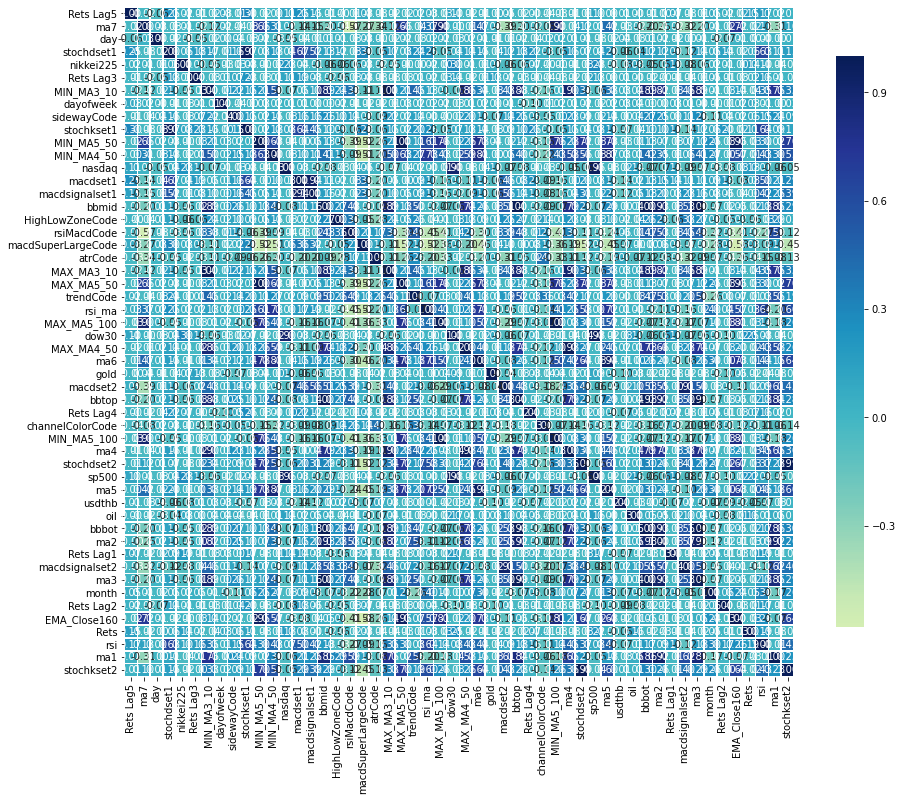

In [58]:
# ดู correlation ระหว่าง feature ด้วยกราฟ heatmap 
import seaborn as sns
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();

d = pd.DataFrame(data=X_train,
                 columns=feature_names)
correlation_heatmap(d[feature_names[sorted_idx]])

XGBoost — Extreme Gradient Boosting เป็น model ที่นำเอา Decision Tree มา train ต่อๆกันหลายๆ tree โดยที่แต่ละ decision tree จะเรียนรู้จาก error ของ tree ก่อนหน้า ทำให้ความแม่นยำของในการทำ prediction จะ แม่นยำมากขึ้นเรื่อยๆ เมื่อมีการเรียนรู้ของ tree ต่อเนื่องกันจนมีความลึกมากพอ และ model จะหยุดเรียนรู้เมื่อไม่เหลือ pattern ของ error จาก tree ก่อนหน้าให้เรียนรู้แล้ว
Classification Tree ใช้ cost function เป็น Gini impurity หรือ Entropy เป็น split point เพื่อความเหมาะสมกับปัญหา classification
Regression Tree ใช้ cost function เป็น RSS (residual sum of squares) เพื่อความเหมาะสมกับปัญหา regression

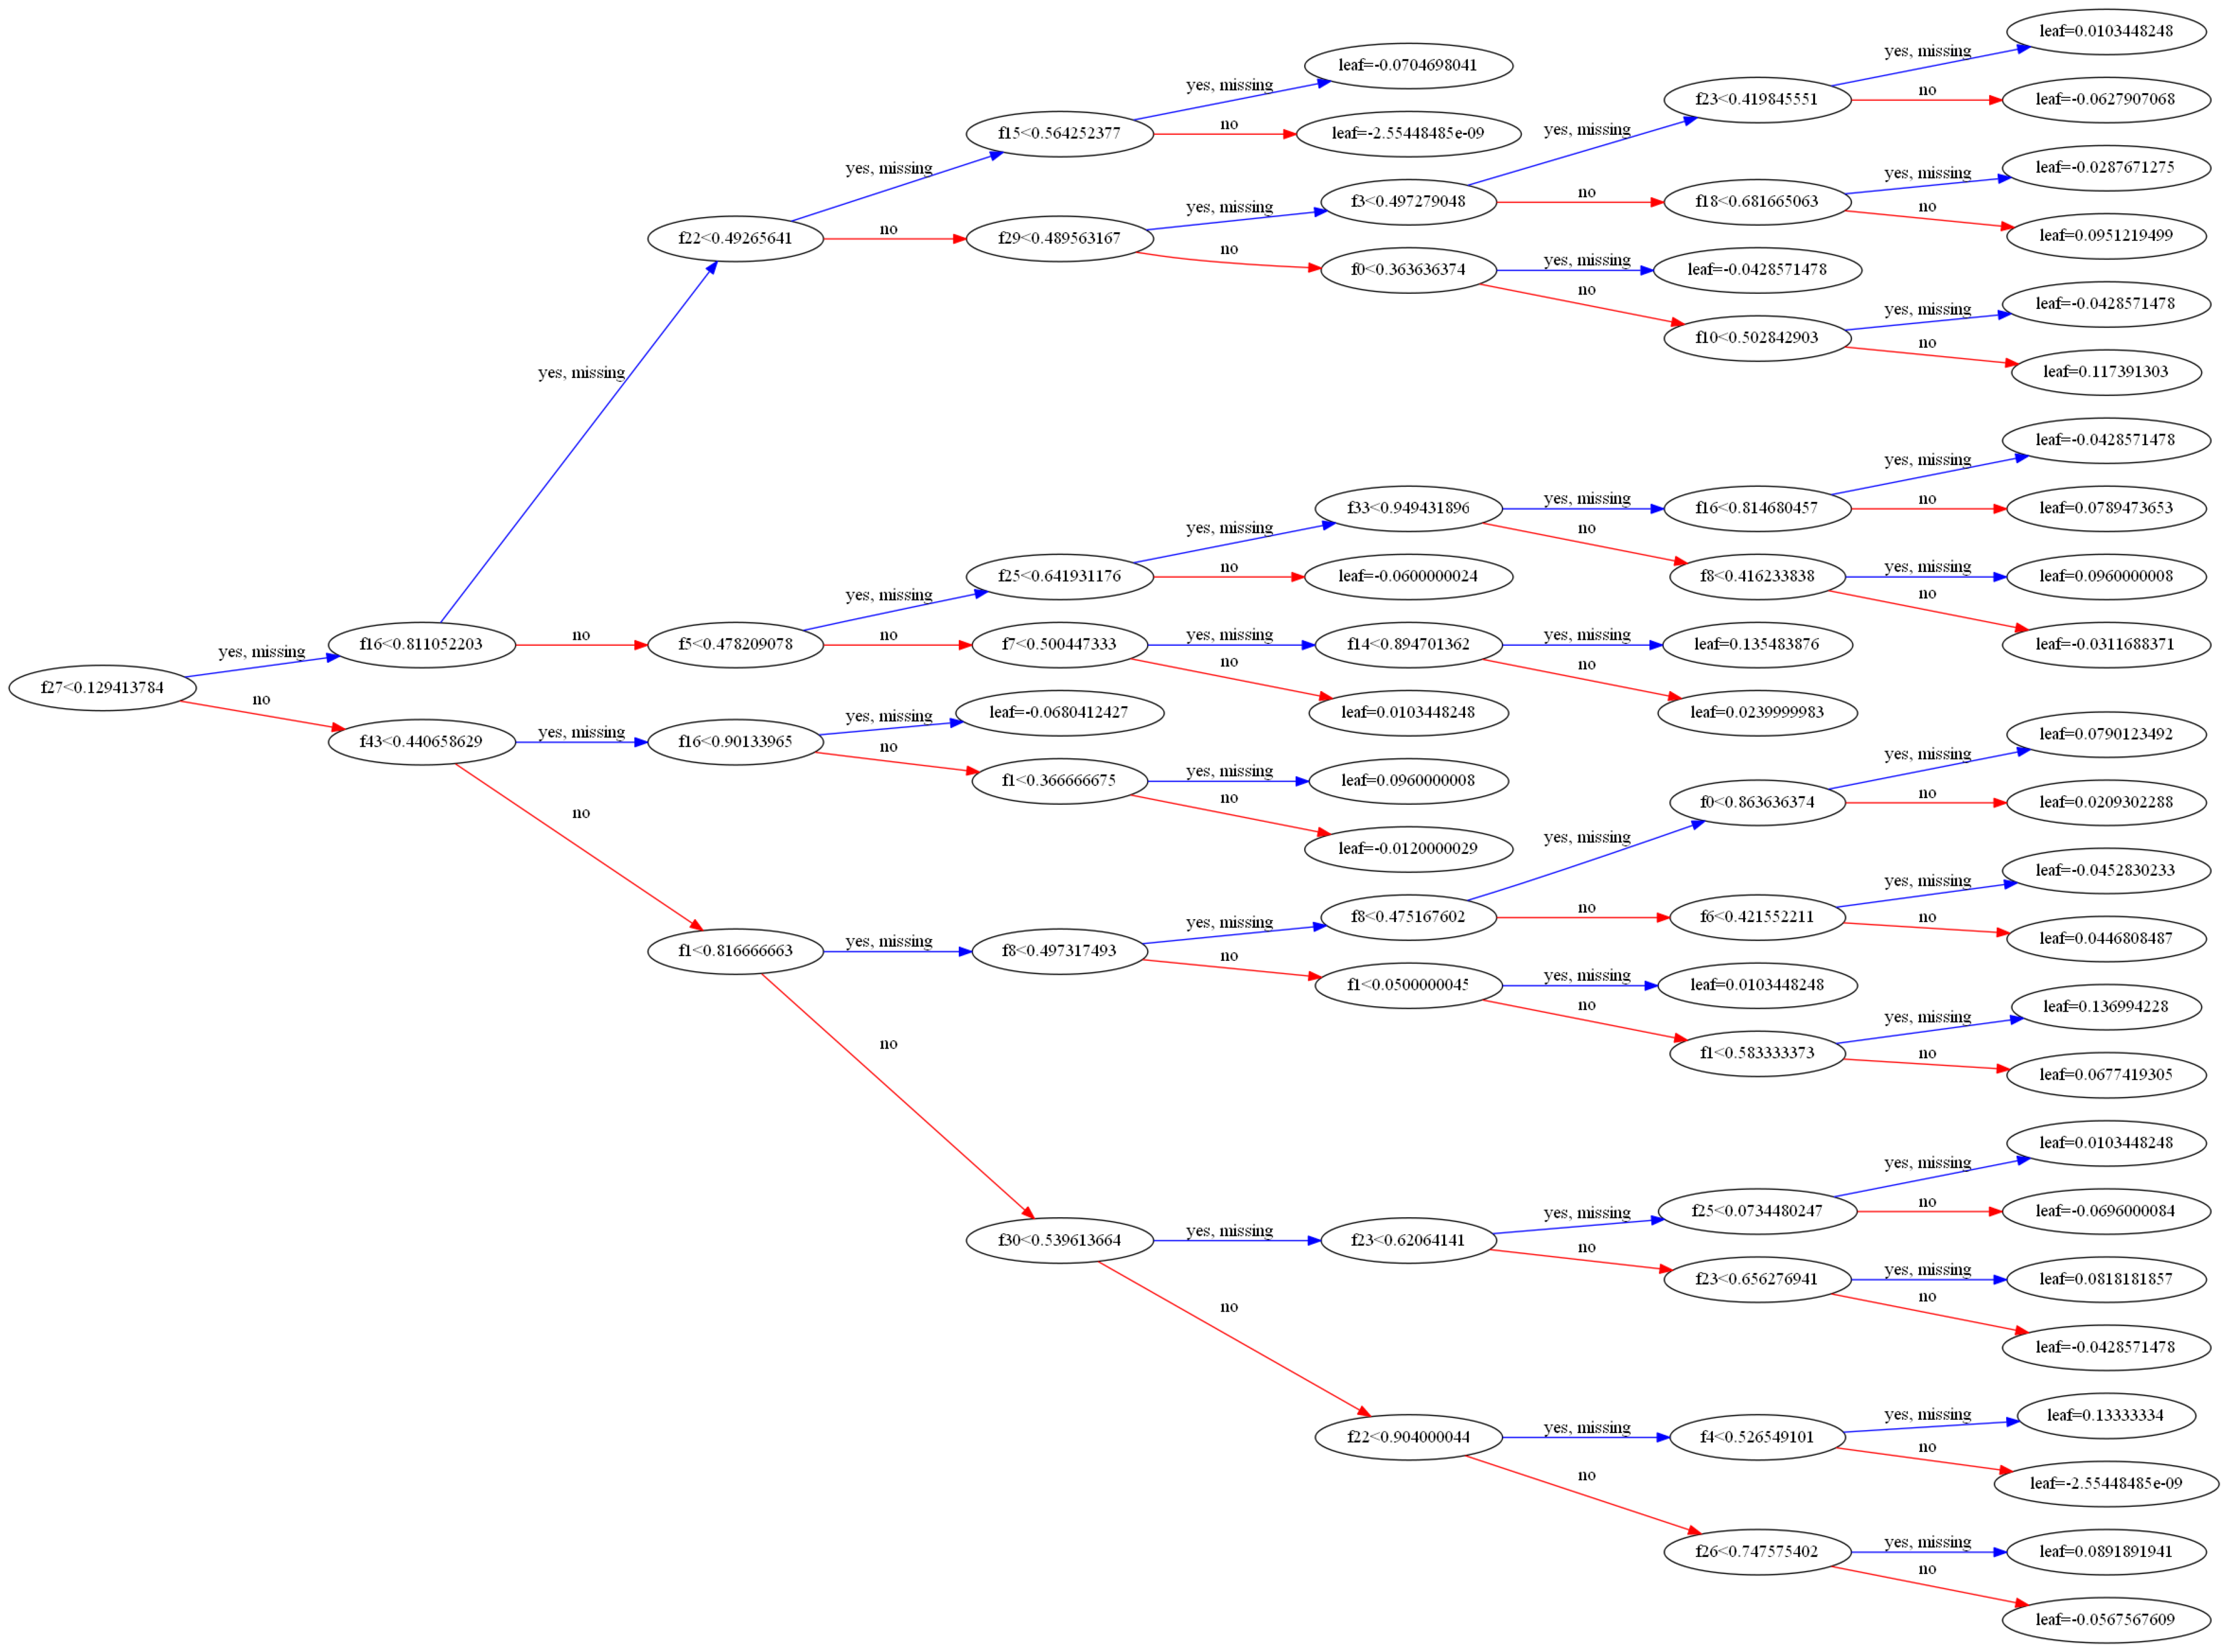

In [59]:
# plot graph ให้เห็น model tree ที่สร้าง
from xgboost import plot_tree
from matplotlib.pylab import rcParams
# plot single tree
rcParams['figure.figsize'] = 80,50
plot_tree(modelC2, rankdir='LR')
plt.show()
# ไม่ได้ map feature name

### 2.2.4 Test Set Classification Accuracy

In [60]:
#from sklearn.metrics import accuracy_score
xgb_predicted = modelC2.predict(X_test)
print(xgb_predicted.astype(int).tolist())
print(Y_test.astype(int).to_list())
acc_xgb = accuracy_score(Y_test,xgb_predicted) * 100.0
print('Accuracy: %.2f%%' % acc_xgb)

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1]
Accuracy: 47.50%


## 2.3 สร้าง model Regression ด้วย Deep Neural Network เพื่อทำนายกำไร
เลือกใช้ model deep neural network เพราะข้อมูลหุ้นซับซ้อนมาก เป็น non-linear และมี noise เยอะมาก 
- ใช้ทำนายค่าตัวเลขให้ใช้ model regression  และ performance ของ model regression วัดด้วยค่า error(loss) ไม่ใช่ accuracy
* ข้อควรระวังเช่น การทำนายค่ากำไรที่เป็น percent change หรือราคา close ก็ตาม regression วัดด้วย error ที่ห่างจากค่าจริง เช่น 0.01 หรือ -0.01 ก็ error น้อยเท่ากัน แต่คนละทิศทาง regression ไม่ได้บอกทิศทาง

### 2.3.1 สร้าง model

In [61]:
# create model regression
def create_model_regression(): # for tune param ex. optimizer='adam',learn_rate=0.01, momentum=0,init_mode='uniform',dropout_rate=0.0
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='sigmoid', activity_regularizer=l2(0.0001), kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.0))
    model.add(Dense(256, activation='relu', activity_regularizer=l2(0.0001), kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.0))    
    model.add(Dense(32, activation='linear', activity_regularizer=l2(0.0001), kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.0))
    model.add(Dense(1))
    # Make parallel using multi-gpu
    #model = make_parallel(model, 3)

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #optimizer = SGD(lr=0.001, momentum=0.9, decay=0.01, nesterov=True)
    #optimizer = Adadelta(lr=2.0, rho=0.99, epsilon=1e-08, decay=0.0)  
    #optimizer = Adagrad(lr=0.001, epsilon=1e-07)
    #optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-07)

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    return model

เสริมการ evaluate model ด้วยการทำ KFold cross validaiton เพื่อไม่ให้ Model overfitting กับช่วงใดช่วงหนึ่ง

In [62]:
# evaluate model ด้วย KFold cross validation
# Z_train คือค่า pencent change ล่วงหน้า 5 วัน ที่ต้องการทำนาย
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X_train, Z_train):
    # create model
    modelR1 = create_model_regression()
    # fit the model 
    history = modelR1.fit(X_train[train], Z_train[train], validation_split=0.33, epochs=250, batch_size=64, verbose=1)
    # evaluate the model 
    scores = modelR1.evaluate(X_train[test], Z_train[test], verbose=1)
    print("%s: %.5f%%" % (modelR1.metrics_names[1], history.history['val_mean_squared_error'][-1]))
    cvscores.append(history.history['val_mean_squared_error'][-1])
#filename = stock_symbol +"_R.h5"
#modelR1.save(filename)

n_squared_error: 8.0604e-04 - val_loss: 0.0083 - val_mean_squared_error: 0.0066
Epoch 135/250
381/381 [==============================] - 0s 108us/step - loss: 0.0017 - mean_squared_error: 7.9643e-04 - val_loss: 0.0084 - val_mean_squared_error: 0.0066
Epoch 136/250
381/381 [==============================] - 0s 102us/step - loss: 0.0017 - mean_squared_error: 7.9656e-04 - val_loss: 0.0083 - val_mean_squared_error: 0.0066
Epoch 137/250
381/381 [==============================] - 0s 168us/step - loss: 0.0017 - mean_squared_error: 7.9778e-04 - val_loss: 0.0084 - val_mean_squared_error: 0.0066
Epoch 138/250
381/381 [==============================] - 0s 126us/step - loss: 0.0017 - mean_squared_error: 7.9827e-04 - val_loss: 0.0083 - val_mean_squared_error: 0.0066
Epoch 139/250
381/381 [==============================] - 0s 113us/step - loss: 0.0017 - mean_squared_error: 8.1943e-04 - val_loss: 0.0082 - val_mean_squared_error: 0.0066
Epoch 140/250
381/381 [==============================] - 0s 121us

In [63]:
print("%s: %.5f%% (+/- %.5f%%)" % (modelR1.metrics_names[1], numpy.mean(cvscores), numpy.std(cvscores)))

mean_squared_error: 0.00742% (+/- 0.00096%)


พล็อตกราฟ loss และกราฟ accuracy ดูเพื่อกลับไปปรับปรุง model ไม่ให้เกิดการ overfit หรือ underfit ของ model

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


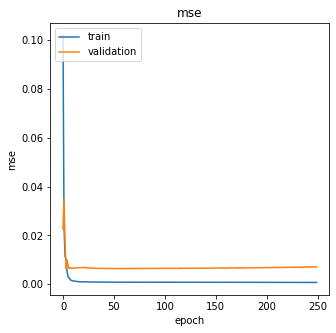

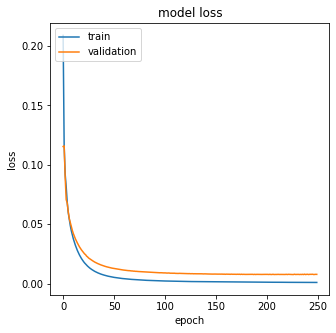

In [64]:
def show_graph(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(5,5))
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(5,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
show_graph(history)

### 2.3.2 Grid Search Hyperparameter - KerasRegressor
tune model ด้วยการทำ grid search optimization เพื่อปรับ hyperparameter ของ neural network ให้ได้ lost function น้อยที่สุด

In [65]:
# # uncomment for tune hyperparameters
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasRegressor
# # create model
# modelR1 = KerasRegressor(build_fn=create_model_regression, verbose=1)
# # define the grid search parameters
# batch_size = [64, 128, 256] #128
# epochs = [50, 100, 150, 200, 250] #200
# optimizer = ['rmsprop', 'adam', 'adamax', 'sgd', 'adagrad'] #rmsprop
# learn_rate = [0,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] #0.2
# beta = [0.7,0.8, 0.9, 0.99, 0.999, 0.9999]
# momentum = [0.0, 0.2, 0.4, 0.6] #0.6
# init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
# activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# activation1 = ['relu', 'tanh', 'sigmoid', 'linear']
# activation2 = ['relu', 'tanh', 'sigmoid', 'linear']
# activation3 = ['relu', 'tanh', 'sigmoid', 'linear']
# dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] #0.2
# neurons1 = [32, 64, 256]
# neurons2 = [32, 64, 128, 256]
# neurons3 = [32, 64, 256]

# #param_grid = dict(activation1=activation1,activation2=activation2,activation3=activation3)
# param_grid = dict(neurons1=neurons1,neurons2=neurons2,neurons3=neurons3)

# kfold_splits = 3
# grid = GridSearchCV(estimator=modelR1, param_grid=param_grid, cv=kfold_splits, n_jobs=-1)
# grid_result = grid.fit(X_train, Z_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

### 2.2.3 Feature Importance
รัน feature importance เพื่อดูว่า feature ไหนที่มีอิทธิพลต่อ model KerasRegressor บ้าง

Epoch 1/1
712/712 [==============================] - 2s 3ms/step - loss: 0.0830 - mean_squared_error: 0.0300
Feature: 0, Score: 0.00002, Name: month
Feature: 1, Score: -0.00000, Name: day
Feature: 2, Score: 0.00001, Name: dayofweek
Feature: 3, Score: 0.00002, Name: Rets
Feature: 4, Score: -0.00001, Name: Rets Lag1
Feature: 5, Score: 0.00000, Name: Rets Lag2
Feature: 6, Score: 0.00000, Name: Rets Lag3
Feature: 7, Score: -0.00001, Name: Rets Lag4
Feature: 8, Score: -0.00000, Name: Rets Lag5
Feature: 9, Score: 0.00000, Name: nasdaq
Feature: 10, Score: 0.00001, Name: dow30
Feature: 11, Score: 0.00000, Name: sp500
Feature: 12, Score: 0.00002, Name: nikkei225
Feature: 13, Score: 0.00000, Name: gold
Feature: 14, Score: -0.00001, Name: oil
Feature: 15, Score: -0.00001, Name: usdthb
Feature: 16, Score: 0.00006, Name: ma1
Feature: 17, Score: -0.00005, Name: ma2
Feature: 18, Score: -0.00006, Name: ma3
Feature: 19, Score: -0.00004, Name: ma4
Feature: 20, Score: -0.00002, Name: ma5
Feature: 21, Sco

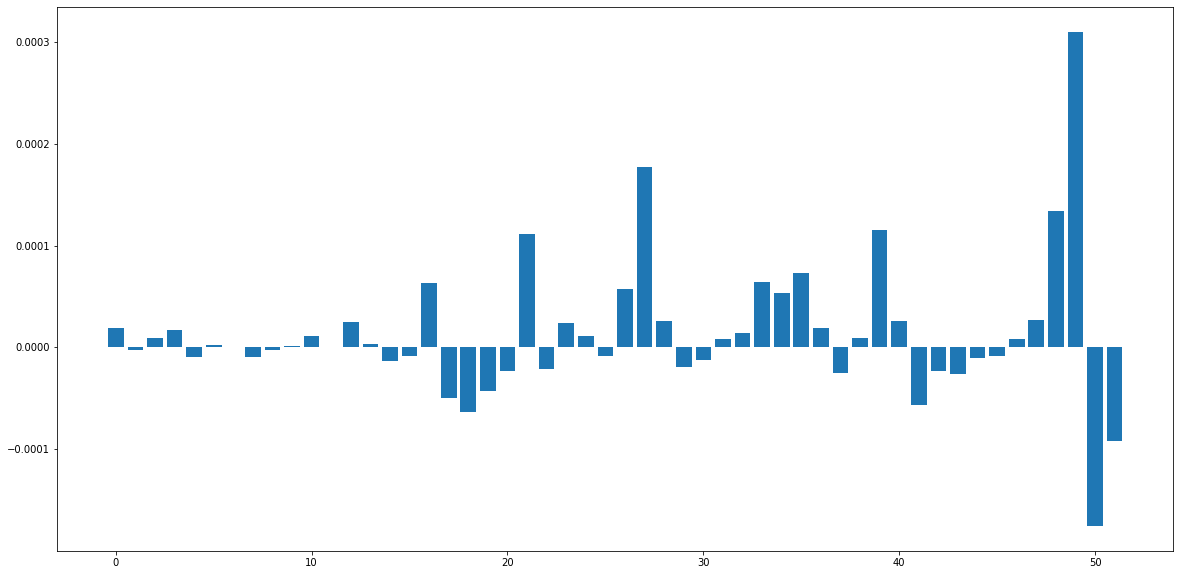

In [66]:
# Method 1
from sklearn.inspection import permutation_importance
#import sklearn.inspection
wrapper_model = KerasRegressor(build_fn=create_model_regression)
# fit the model
wrapper_model.fit(X_train, Z_train) #scikit learn only take 2D input here
# perform permutation importance
results = permutation_importance(wrapper_model, X_train, Z_train, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f, Name: %s' % (i,v,final_ds.columns[5:-6][i]))
# plot feature importance
plt.figure(figsize=(20, 10))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [67]:
# Method 2
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

my_model = KerasRegressor(build_fn=create_model_regression)    
my_model.fit(X_train, Z_train)

perm = PermutationImportance(my_model, random_state=1).fit(X_train, Z_train)
eli5.show_weights(perm, feature_names = final_ds.columns[5:-6].tolist(), top=100)

Epoch 1/1
712/712 [==============================] - 0s 74us/step


### 2.3.4 Test Set Regression Error

In [68]:
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = modelR1.predict(X_test,)
rmse_dnn = sqrt(mean_squared_error(Z_test, predictions))
#print(predictions.shape)
#print(predictions.tolist())
#print(Z_test.shape)
#print(Z_test.to_list())
print('rmse: %.5f%%' % rmse_dnn) # root mean squared error

rmse: 0.05471%


### 2.3.5 Visualization

In [69]:
# predict list
Z_pred = modelR1.predict(X)

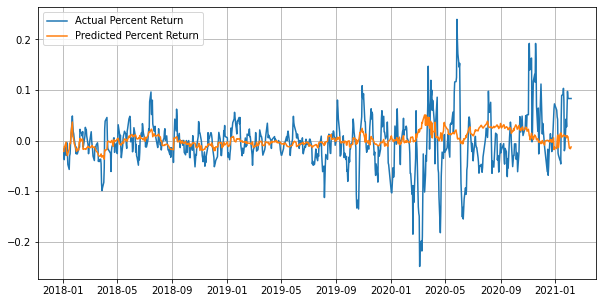

In [70]:
# Compare Return_Price and Predicted_Return_Price
plt.figure(figsize=(10, 5))
plt.plot(dataframe.index, Z, label='Actual Percent Return')
plt.plot(dataframe.index, Z_pred, label='Predicted Percent Return')
plt.grid()
plt.legend()
plt.show()

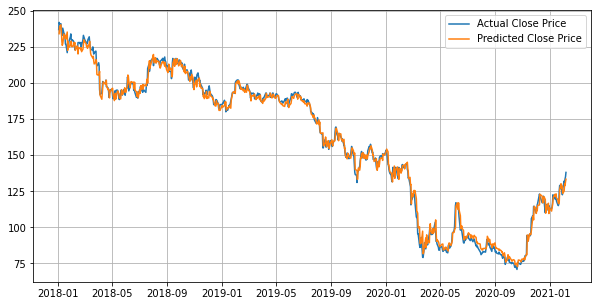

In [71]:
# Revert Return_Price back to Close_Price
close = (dataframe['close'])
close_p = (dataframe['close'].shift(1)*(Z_pred[:,0]+1))
plt.figure(figsize=(10, 5))
plt.plot(dataframe.index, close, label='Actual Close Price')
plt.plot(dataframe.index, close_p, label='Predicted Close Price')
plt.grid()
plt.legend()
plt.show()

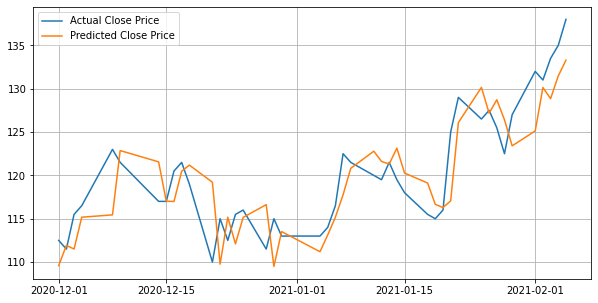

In [72]:
# Revert Return_Price back to Close_Price
close = (dataframe['close'])
close_p = (dataframe['close'].shift(1)*(Z_pred[:,0]+1))
plt.figure(figsize=(10, 5))
plt.plot(dataframe.iloc[-44:].index, close.iloc[-44:], label='Actual Close Price')
plt.plot(dataframe.iloc[-44:].index, close_p.iloc[-44:], label='Predicted Close Price')
plt.grid()
plt.legend()
plt.show()
# ถ้ากราฟดูคล้ายๆการ shift แสดงว่าค่า predict ยังไม่แม่น

### Predict Result

In [73]:
#filename = stock_symbol +"_R.h5"
#modelR1 = load_model(filename)

# calculate predictions
predict = modelR1.predict(X_test)
predict_return2 = predict[-1,0]
current_price = df.iloc[-1,3]
#print('predict up=1 down=-1 sideway=0 ', predicted_labels1[-1])
print('current_price ','{:.3f}'.format(current_price))
print('predict_5day_price ','{:.3f}'.format(((predict_return2)+1)*current_price))   #simple return
print('predict_return ','{:.3f}'.format(predict_return2*100),'%') 

#tp = current_price + triple_barrier_events.iloc[-1,1]
#sl = current_price - triple_barrier_events.iloc[-1,1]
#print('take_profit ','{:.3f}'.format(tp))
#print('stop_loss ','{:.3f}'.format(sl))

current_price  138.000
predict_5day_price  139.026
predict_return  0.743 %


## 2.4 สร้าง model Regression ด้วย Stacked LSTM เพื่อทำนายกำไร
เลือกใช้ model LSTM เพราะข้อมูลหุ้นเป็น time series แต่ความยากก็คือมี noise หรือ residual เยอะมาก 
ในที่นี้ใช้ทำนายค่าแบบ regression ทำนายค่ากำไร
### 2.4.1 แปลง data สำหรับ LSTM
การจะใช้ LSTM เราต้อง reshape dataset ของเราใหม่ซะก่อน และต้องเป็น shape ใหม่ทั้ง train, label trian, test, label test
* Batch Size จำนวน data ที่ให้เห็น ก่อนการ update weight  
* Time Steps จำนวน period ย้อนหลังที่ใช้ในการทำนาย
* Features จำนวน featues ที่ใช้ในแต่ละ time step 

- ตามรูปจะมี 3 Time Steps และ 5 Features แต่ไม่ได้บอกขนาด Batch Size
- Target (หรือ Label) ไม่จำเป็นต้องเป็น next day
- 0-2 คือ batch ที่ 1  
- 1-3 คือ batch ที่ 2 

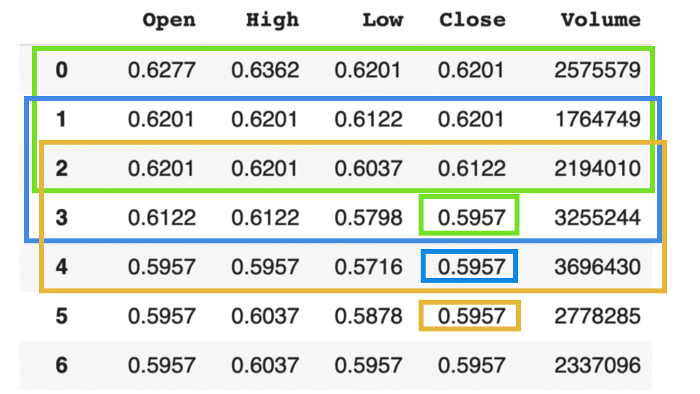


In [74]:
# สร้างฟังก์ชั่นสำหรับแปลง input data
from tqdm.notebook import tqdm
TIME_STEPS = 5
BATCH_SIZE = 10

def build_timeseries(mat, mat_y):
    
#     Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
#     number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
#     :param mat: ndarray which holds the dataset
#     :param y_col_index: index of column which acts as output
#     :return: returns two ndarrays-- input and output in format suitable to feed
#     to LSTM.
    
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    #print("dim_0",dim_0)
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat_y[TIME_STEPS+i]
#         if i < 10:
#             print(i,"-->", x[i,-1,:], y[i])
    #print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat,batch_size):
    #trims dataset to a size that's divisible by BATCH_SIZE
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [75]:
print(X_train.shape)
# reshape input to 3D
# แปลง input สำหรับ LSTM  Batch_size, Time_steps, features
X_train_ts, Y_train_ts = build_timeseries(X_train, Z_train)
X_train_ts = trim_dataset(X_train_ts, BATCH_SIZE)
Y_train_ts = trim_dataset(Y_train_ts, BATCH_SIZE)
print("Batch trimmed size",X_train_ts.shape, Y_train_ts.shape)

x_temp, y_temp = build_timeseries(X_test, Z_test)
X_val, X_test_ts = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
Y_val, Y_test_ts = np.split(trim_dataset(y_temp, BATCH_SIZE),2)
print("Test size", X_test_ts.shape, Y_test_ts.shape, X_val.shape, Y_val.shape)


(712, 52)
Batch trimmed size (700, 5, 52) (700,)
Test size (15, 5, 52) (15,) (15, 5, 52) (15,)


### 2.4.2 สร้าง model

In [76]:
# create model LSTM
def create_model_LSTM(): 
    model = Sequential() 
    model.add(LSTM(50, batch_input_shape=(BATCH_SIZE, TIME_STEPS, X_train_ts.shape[2]), activation='relu', return_sequences=True))
    model.add(Dropout(0.4))
    model.add(LSTM(50, activation='relu'))   
    model.add(Dropout(0.4))
    model.add(Dense(1))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    #optimizer = SGD(lr=0.001, momentum=0.9, decay=0.01, nesterov=True)
    #optimizer = Adadelta(lr=2.0, rho=0.99, epsilon=1e-08, decay=0.0)  
    #optimizer = Adagrad(lr=0.001, epsilon=1e-07)
    #optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-07)

    # Compile model
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_error'])
    return model

LSTM ไม่ควรทำ KFold Cross Validation เพราะเราใช้ model ที่เป็น time series

In [77]:
cvscores = []
# create model
modelR2 = create_model_LSTM()
# fit the model 
history = modelR2.fit(X_train_ts, Y_train_ts, epochs=100, batch_size=BATCH_SIZE, verbose=1
                     , validation_data=(trim_dataset(X_val, BATCH_SIZE),
                        trim_dataset(Y_val, BATCH_SIZE)))
# evaluate the model 
scores = modelR2.evaluate(X_train_ts, Y_train_ts, batch_size=BATCH_SIZE, verbose=1)
print("%s: %.5f%%" % (modelR2.metrics_names[1], history.history['val_mean_squared_error'][-1]))
cvscores.append(history.history['mean_squared_error'][-1])

Train on 700 samples, validate on 10 samples
Epoch 1/100
700/700 [==============================] - 5s 7ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 2/100
700/700 [==============================] - 1s 1ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/100
700/700 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 7.9650e-04 - val_mean_squared_error: 7.9650e-04
Epoch 4/100
700/700 [==============================] - 1s 1ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 5/100
700/700 [==============================] - 1s 1ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 6.1811e-04 - val_mean_squared_error: 6.1811e-04
Epoch 6/100
700/700 [==============================] - 1s 1ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0

In [78]:
print("%s: %.5f%% (+/- %.5f%%)" % (modelR2.metrics_names[1], numpy.mean(cvscores), numpy.std(cvscores)))

mean_squared_error: 0.00102% (+/- 0.00000%)


พล็อตกราฟ loss และกราฟ accuracy ดู เพื่อกลับไปปรับปรุง model ไม่ให้เกิดการ overfit หรือ underfit ของ model

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


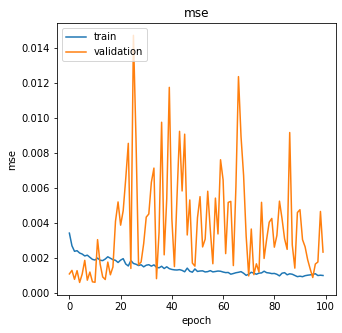

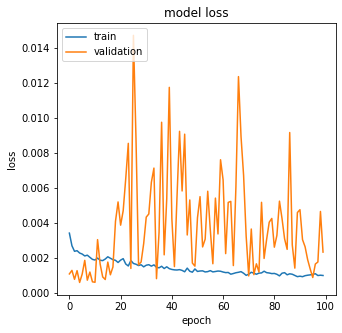

In [79]:
def show_graph(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(5,5))
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(5,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
show_graph(history)

ไม่สามารถทำ feature importance แบบธรรมดาได้ เพราะ features X มี 3 dimensions

### 2.4.3 Test Set LSTM error

In [80]:
from sklearn.metrics import mean_squared_error
from math import sqrt

predict_lstm = modelR2.predict(trim_dataset(X_test_ts, BATCH_SIZE), batch_size=BATCH_SIZE)
predict_lstm = predict_lstm.flatten()
Y_test_ts = trim_dataset(Y_test_ts, BATCH_SIZE)
rmse_lstm = sqrt(mean_squared_error(Y_test_ts, predict_lstm))
#print(predict_lstm.shape)
#print(predict_lstm.tolist())
#print(Y_test_ts.shape)
#print(Y_test_ts)
print('rmse: %.5f%%' % rmse_lstm)

rmse: 0.06411%


### 2.4.4 Visualization

In [81]:
# predict list
new_X = numpy.concatenate((X_train_ts, X_test_ts))
new_Y = numpy.concatenate((Y_train_ts, Y_test_ts))
Y_pred = modelR2.predict(trim_dataset(new_X, BATCH_SIZE), batch_size=BATCH_SIZE)
Y_pred = Y_pred.flatten()
new_Y = trim_dataset(new_Y, BATCH_SIZE)
print(Y_pred.shape[0])
print(new_Y.shape[0])
#print(dataframe.shape[0])

710
710


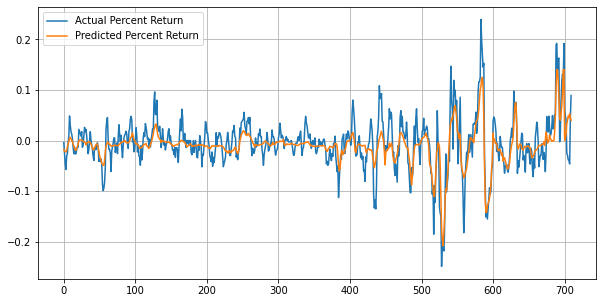

In [82]:
# Compare Return_Price and Predicted_Return_Price
plt.figure(figsize=(10, 5))
#plt.plot(dataframe.index, Z, label='Actual Percent Return')
plt.plot(new_Y, label='Actual Percent Return')
plt.plot(Y_pred, label='Predicted Percent Return')
plt.grid()
plt.legend()
plt.show()

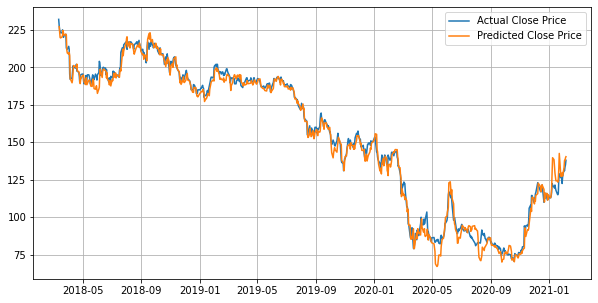

In [83]:
# Revert Return_Price back to Close_Price
shift = dataframe.shape[0]-Y_pred.shape[0]
close = (dataframe['close'])
close = close[shift:]
#print(close)
close_p = (close.shift(1)*(Y_pred+1))
#print(Y_pred+1)
plt.figure(figsize=(10, 5))
plt.plot(close.index, close, label='Actual Close Price')
plt.plot(close.index, close_p, label='Predicted Close Price')
plt.grid()
plt.legend()
plt.show()

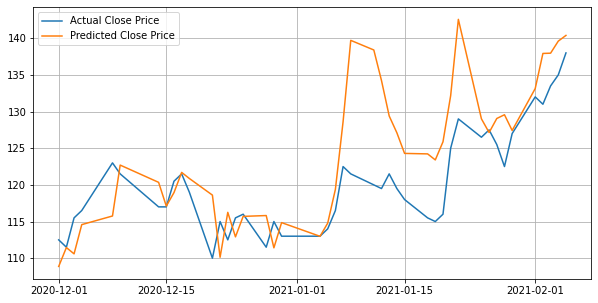

In [84]:
# Revert Return_Price back to Close_Price
#close = (dataframe['close'])
#close_p = (dataframe['close'].shift(1)*(Z_pred[:,0]+1))
plt.figure(figsize=(10, 5))
plt.plot(dataframe.iloc[-44:].index, close.iloc[-44:], label='Actual Close Price')
plt.plot(dataframe.iloc[-44:].index, close_p.iloc[-44:], label='Predicted Close Price')
plt.grid()
plt.legend()
plt.show()

### Predict Result

In [85]:
# calculate predictions
last_row = X_test_ts[-BATCH_SIZE:,:].astype(float)
predict = modelR2.predict(last_row)
predict_return3 = predict[-1,0]
current_price = df.iloc[-1,3]
print('current_price ','{:.3f}'.format(current_price))
print('expect_price ','{:.3f}'.format(((predict_return3)+1)*current_price))   #simple return
print('predict_return ','{:.3f}'.format(predict_return3*100),'%') 

#tp = current_price + triple_barrier_events.iloc[-1,1]
#sl = current_price - triple_barrier_events.iloc[-1,1]
#print('take_profit ','{:.3f}'.format(tp))
#print('stop_loss ','{:.3f}'.format(sl))

current_price  138.000
expect_price  137.109
predict_return  -0.646 %


# 3. ทำนายค่า

In [86]:
# เลือกโดย
# เที่ยบ Classification DNN กับ XGBoost เลือกอันที่ accuracy มากกว่า
print('เลือกที่ accuracy มากกว่า ควรมากกว่า 60%')
print('classification DNN accuracy ', '{:.3f}'.format(acc_dnn),'%')
print('classification XGB accuracy ', '{:.3f}'.format(acc_xgb),'%')
if acc_dnn > acc_xgb:
    temp_predict = model.predict(X_last)  # X_last คือ unseen data
    predict_class_dnn = encoder.inverse_transform(np.argmax(temp_predict,1))
    print('predict classification DNN (1,-1,0) ', predict_class_dnn[-1])
else:
    predict_class_xgb = modelC2.predict(X_last)
    print('predict classification XGB (1,-1,0) ', predict_class_xgb[-1])
    
# เทียบ Regression DNN กับ LSTM เลือกอันที่ค่า error น้อยกว่า
print('เลือกค่าที่ rmse น้อยกว่า (rmse = root mean square error)')
print('regression DNN rmse ', '{:.3f}'.format(rmse_dnn))
print('regression LSTM rmse ', '{:.3f}'.format(rmse_lstm))
print('current price ',end_date,' {:.3f}'.format(current_price))
if rmse_dnn < rmse_lstm:
    temp_predict2 = modelR1.predict(X_last)
    predict_regress_dnn = temp_predict2[-1,0]
    print('predict 5d price regression DNN ','{:.3f}'.format(((predict_regress_dnn)+1)*current_price))   #simple return
else:
    concat_X = numpy.concatenate((X_test, X_last))
    concat_Z = numpy.concatenate((Z_test, Z_last))
    x_temp, z_temp = build_timeseries(concat_X, concat_Z)
    last_batch = x_temp[-BATCH_SIZE:,:].astype(float)
    temp_predict3 = modelR2.predict(last_batch)
    predict_lstm = temp_predict3[-1,0]
    print('predict 5d price regression LSTM ','{:.3f}'.format(((predict_return3)+1)*current_price))   #simple return


เลือกที่ accuracy มากกว่า ควรมากกว่า 60%
classification DNN accuracy  47.500 %
classification XGB accuracy  47.500 %
predict classification XGB (1,-1,0)  -1.0
เลือกค่าที่ rmse น้อยกว่า (rmse = root mean square error)
regression DNN rmse  0.055
regression LSTM rmse  0.064
current price  2021-02-06 16:20:06.005304  138.000
predict 5d price regression DNN  136.255


* ระบบไม่สามารถทำนายการเกิด noise ได้ โปรดระวัง เช่นอาจเกิดเหตุการณ์ไม่คาดฝันใน 5 วันข้างหน้า เพราะฉะนั้นควรมี stop loss ไว้ด้วย
* การนำ model ที่ train แล้วไป predict ค่าอย่างเดียว ก็ต้องเตรียม data ในข้อ 1 ด้วย

สิ่งที่ทำต่อ
1. แก้ bug ที่เจอภายหลัง
2. ปรับปรุง model ให้ถูกต้องมากขึ้น และ generalize
3. clean code 
4. หา feature เพิ่มที่เหมาะสม
5. ใช้ Reinforcement Learning หาจุด buy/sell, 
6. ทำฟังก์ชั่นหาค่า take profit/stop loss, กำหนด lot size
7. ทำเป็น api ต่อ chatbot เพื่อทำนายแบบ manual
8. ทำ model ใส่ระบบ auto trade
9. ทำ scan หุ้น SET100 ด้วย XGBoost Regression เพราะเร็ว
10. ...




### ของแถม รันสแกนหุ้น SET100 100 ตัว ด้วย XGBRegrassor 
ยังไม่แม่นนะ

In [87]:
import starfishX as sx
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
seed = 1234

In [88]:
# get dataframe of SET100 stocks 
set100s = sx.getMemberOfIndex(sx.indexMarket.SET100)
# convert series to list containing stock name : can be used in loop later
slist = set100s['symbol'].to_list()
tslist = []
for i in range(len(slist)):
    tslist.append(slist[i])

In [89]:
# Create get_stock function to pull stock data จาก startfishX จะเป็นข้อมูลรายวัน daily 
def get_stock(stock, startdate, enddate):
    df = sx.loadHistData(stock, start=startdate, end=enddate, OHLC=True, Volume=True)
    return df

In [90]:
def getseries(stockname):
    df = get_stock(stock=stockname, startdate=start_date, enddate=end_date)
    df = df['CLOSE']
    return df

In [91]:
def prepare_data(series):
    rets = pd.DataFrame(series, copy=True)
    rets['ret'] = np.log(rets['CLOSE']/rets['CLOSE'].shift(1))
    for n in range(1,4):
         cols = 'RetsLag'+str(n)    
         rets[cols] = rets['ret'].shift(n)   
    rets['ma1'] = talib.WMA(rets['CLOSE'], timeperiod=5)   # WMA 5
    #rets['ma2'] = talib.EMA(rets['CLOSE'], timeperiod=10)  # EMA 10
    rets['ma3'] = talib.SMA(talib.EMA(rets['CLOSE'], 15), 2)
    #rets['ma4'] = talib.EMA(talib.EMA(rets['CLOSE'], 30), 3)
    rets['ma5'] = talib.EMA(talib.EMA(rets['CLOSE'], 100), 2)   
    rets['MIN_MA3_10'] = FELib.llv(rets['ma3'], 10)
    #rets['MIN_MA4_50'] = FELib.llv(rets['ma4'], 50)
    #rets['MAX_MA4_50'] = FELib.hhv(rets['ma4'], 50)
    rets['MIN_MA5_100'] = FELib.llv(rets['ma5'], 100)
    rets['MAX_MA5_100'] = FELib.llv(rets['ma5'], 100)
    rets = rets.fillna(0)
    
    target = np.log(rets['CLOSE'].shift(-p_day)/rets['CLOSE'])
    target = target.fillna(0) 
    return rets, target

In [92]:
def trainmodel(rets, target):
    modelR3 = XGBRegressor(objective='reg:squarederror', max_depth=5, random_state=seed, learning_rate=0.1)
    X_train_XGB, X_val, Z_train_XGB, Z_val = train_test_split(rets, target, test_size=0.33, random_state=seed)
    eval_set = [(X_train_XGB, Z_train_XGB), (X_val, Z_val)]
    modelR3.fit(X_train_XGB, Z_train_XGB, early_stopping_rounds=10, eval_set=eval_set, verbose=False)
    return modelR3

In [93]:
def predict(rets, model):
    prediction = model.predict(rets)
    return prediction

In [94]:
resultdict={}
i=1
for stockname in tslist:
    print(stockname)
    series = getseries(stockname = stockname)
    #print(series.tail())
    
    rets, target = prepare_data(series)  
    #print(target.tail())
    # Rescale Data
    scaler = MinMaxScaler(feature_range=(0,1))
    rets = scaler.fit_transform(rets)
    
    modelR3 = trainmodel(rets, target)
    pred = predict(rets[-1:], modelR3)
    #print(pred)
    resultdict[stockname] = pred
    print(i)
    i=i+1

ACE
1
ADVANC
2
AEONTS
3
AMATA
4
AOT
5
AP
6
AWC
7
BAM
8
BANPU
9
BBL
10
BCH
11
BCP
12
BCPG
13
BDMS
14
BEC
15
BEM
16
BGRIM
17
BH
18
BJC
19
BPP
20
BTS
21
CBG
22
CENTEL
23
CHG
24
CK
25
CKP
26
COM7
27
CPALL
28
CPF
29
CPN
30
CRC
31
DELTA
32
DOHOME
33
DTAC
34
EA
35
EGCO
36
EPG
37
ESSO
38
GFPT
39
GLOBAL
40
GPSC
41
GULF
42
GUNKUL
43
HANA
44
HMPRO
45
INTUCH
46
IRPC
47
IVL
48
JAS
49
JMART
50
JMT
51
KBANK
52
KCE
53
KKP
54
KTB
55
KTC
56
LH
57
MAJOR
58
MBK
59
MEGA
60
MINT
61
MTC
62
ORI
63
OSP
64
PLANB
65
PRM
66
PTG
67
PTT
68
PTTEP
69
PTTGC
70
QH
71
RATCH
72
RBF
73
RS
74
SAWAD
75
SCB
76
SCC
77
SCGP


Exception: inputs are all NaN

In [100]:
sorted(resultdict.items(), key=lambda x: x[1], reverse=True)

[('PTTEP', array([0.03515], dtype=float32)),
 ('GULF', array([0.03125], dtype=float32)),
 ('THANI', array([0.02989], dtype=float32)),
 ('DTAC', array([0.02273], dtype=float32)),
 ('MINT', array([0.02060], dtype=float32)),
 ('BGRIM', array([0.02024], dtype=float32)),
 ('PTTGC', array([0.01816], dtype=float32)),
 ('EA', array([0.01652], dtype=float32)),
 ('LH', array([0.01569], dtype=float32)),
 ('TASCO', array([0.01529], dtype=float32)),
 ('TU', array([0.01521], dtype=float32)),
 ('JMT', array([0.01444], dtype=float32)),
 ('CPN', array([0.01426], dtype=float32)),
 ('BBL', array([0.01381], dtype=float32)),
 ('PLANB', array([0.01320], dtype=float32)),
 ('BCPG', array([0.01246], dtype=float32)),
 ('VGI', array([0.01107], dtype=float32)),
 ('KCE', array([0.01052], dtype=float32)),
 ('GFPT', array([0.01010], dtype=float32)),
 ('HMPRO', array([0.00985], dtype=float32)),
 ('IVL', array([0.00970], dtype=float32)),
 ('TKN', array([0.00961], dtype=float32)),
 ('SCC', array([0.00951], dtype=float3